# Thông tin nhóm 14

1612406 - Đặng Phương Nam

1612423 - Lê Minh nghĩa

# A. Câu hỏi cần trả lời

## 1. Phát biểu câu hỏi

Cho các thông tin về căn nhà:

- Giá cho thuê trước khi bán.
- Địa chỉ.
- Loại nhà.
- Số phòng ngủ.
- Số nhà vệ sinh.
- Diện tích phần nhà.
- Diện tích toàn bộ lô đất.
- Năm xây dựng.
- Tiền thuế.
- Gần mấy trường học.
- Tình hình tội phạm.
- ...

Hỏi giá trị của căn nhà là bao nhiêu tiền?

## 2. Lợi ích khi trả lời được câu hỏi

Nhờ vào thông tin của căn nhà:

- Người bán có thể dự đoán được giá trị căn nhà mà mình muốn bán.
- Người mua có thể ước lượng được căn nhà mình muốn mua có giá cả hợp lý hay không?.
- Dự đoán được giá trị căn nhà của mình.
- ...

# B. Trả lời câu hỏi

Cần kiểm tra lại version của sklearn, nếu chưa phải là `verson 0.22` thì phải update lên `0.22` vì nhóm có sủ dụng `KNN` để điền các giá trị thiếu (missing value) trong bước `Tiền xử lý dữ liệu` và `KNN` chỉ được hỗ trợ trong `version 0.22`.

In [1]:
import sklearn
sklearn.__version__

'0.22'

In [2]:
# Import các thư viện cần thiết
import urllib.robotparser
import json
import os.path
import re
from requests_html import HTMLSession

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## 1. Thu thập dữ liệu

### 1.1. Parse HTML

Dữ liệu thu thập từ trang web https://www.realtytrac.com/. Ta chỉ thu thập dữ liệu "các estate đã được bán tại  California", ta có HTML cần parse: https://m.realtytrac.com/mapsearch/sold/ca/

Thời gian lấy dữ liệu: Ngày 10/12/2019

In [ ]:
rp = urllib.robotparser.RobotFileParser()
rp.set_url('https://m.realtytrac.com/robots.txt')
rp.read()

In [ ]:
# Lấy link chứa danh sách các ngôi nhà đã bán theo Quận tại California
check_parse = rp.can_fetch('*', 'https://m.realtytrac.com/mapsearch/sold/ca/')

base_url = "https://m.realtytrac.com"
list_url_county = []

# Kiểm tra việc parse HTML được cho phép hay không?
if check_parse == True:
    session = HTMLSession()
    r = session.get('https://m.realtytrac.com/mapsearch/sold/ca/')

    counties = r.html.find("option")

    for county in counties:
        tail_url = county.attrs['value']
        if (tail_url):
            url = base_url + tail_url
            list_url_county.append(url)


list_url_county

In [ ]:
# Hàm trả về generator, generator này trả về trang tiếp theo sau mỗi lần duyệt.
def urlGenerator(baseUrl, startPage=1):
    i = startPage
    if i <= 1:
        yield baseUrl
        i = 2
    while True:
        yield f"{baseUrl}/p-{i}"
        i += 1


# Hàm parseDetailPage: parse để lấy thông tin chi tiết của từng căn nhà từ detailUrl (của căn nhà đã bán).
# Tham số: session và detailUrl của căn nhà cần parse.
# Trả về: dictionary chứa các thông tin đã parse được.
def parseDetailPage(session: HTMLSession, detailUrl: str):

    # Lấy mã HTML của trang web.
    r = session.get(detailUrl)

    # Dictionary lưu lại kết quả.
    result = {}

    # Lấy address của estate.
    address = {}
    street = r.html.find("[itemprop = 'streetAddress']", first=True)
    if street is not None:
        street = street.text

    locality = r.html.find("[itemprop = 'addressLocality']", first=True)
    if locality is not None:
        locality = locality.text

    region = r.html.find("[itemprop = 'addressRegion']", first=True)
    if region is not None:
        region = region.text

    code = r.html.find("[itemprop = 'postalCode']", first=True)
    if code is not None:
        code = code.text

    address["street"] = street
    address["locality"] = locality
    address["region"] = region
    address["code"] = code

    result["address"] = address

    # Lấy thông tin ngày đã bán căn nhà.
    date_sold = r.html.find(".recently-sold", first=True)
    if date_sold is not None:
        result["date_sold"] = date_sold.text.replace("SOLD ON ", "")
    else:
        result["date_sold"] = None

    # Lấy giá cho thuê trước khi bán.
    mortgage = r.html.find(".property-price-info", first=True)
    if mortgage is not None:
        result["mortgage"] = mortgage.text.replace("Est. Mortgage: ","")
    else:
        result["mortgage"] = None


    # Lấy phân mô tả chi tiết về căn nhà.
    details = []
    detailTexts = r.html.find(".detail-text")
    if detailTexts is not None:
        for detailText in detailTexts:
            details.append(detailText.html)  # sở dĩ lấy mà HTML để dễ parse sau này (khi muốn lấy thông tin từ details)
    result["details"] = details

    # Lấy property info của căn nhà.
    propertyInfo = r.html.find(".property-info", first=True)
    if propertyInfo is not None:
        info = {}
        items = propertyInfo.find(".item")
        if items is not None:
            for item in items:
                name = item.find(".name", first=True).text.lower().replace(" ", "_")
                value = item.find(".value", first=True).text
                info[name] = value

        result["info"] = info
    else:
        result["info"] = None

    # Lấy property taxes của căn nhà.
    property_taxes = r.html.find(".property-taxes")
    if property_taxes is not None:
        for tax in property_taxes:
            key = tax.find(".section-head", first=True).text.lower().replace(" ", "_")
            taxes = {}
            items = tax.find(".item")
            if items is not None:
                for item in items:
                    name = item.find(".name", first=True).text.lower().replace(" ", "_")
                    value = item.find(".value", first=True).text
                    taxes[name] = value

            result[key] = taxes

    # Lấy số lượng trường học gần đó.
    local_school = r.html.find(".property-schools", first=True)
    num_school = 0
    if local_school is not None:
        num_school = len(local_school.find(".schoolInfo"))

    result["school"] = num_school

    # Lấy thông tin tội phạm trong vùng.
    crimes = {}
    local_crime_index = r.html.find(".property-local-crime", first=True)
    if local_crime_index is not None:
        type_crimes = local_crime_index.find(".gradeTitle")
        if type_crimes is not None:
            for type_crime in type_crimes:
                match = re.match(r"(.+?) = (\d+)", type_crime.text)
                if match is not None:
                    key = match.group(1).lower().replace(' ', '_')
                    value = int(match.group(2))
                    crimes[key] = value

    result["local_crime_index"] = crimes

    # Lấy số lượng nhà bị tịch thu gần đó.
    nearby_foreclosures = r.html.find(".property-nearby-fc", first=True)
    num_fc = 0
    if nearby_foreclosures is not None:
        num_fc = len(nearby_foreclosures.find(".nearby-property"))

    result["foreclosures"] = num_fc

    return result

In [ ]:
# Hàm parseSearchPage: parse theo page (mỗi parse chứa danh sách và url của 25 căn nhà đã được bán).
# Tham số: session và url của page hiện tại.
# Trả về: list thông tin chi tiết của tất cả căn nhà tại page hiện tại và url của page kế tiếp.
def parseSearchPage(session: HTMLSession, urlPage: str):

    # Lấy mã HTML.
    r = session.get(urlPage)

    # Lấu detailUrl của tất cả bất động sản.
    detailUrls = [link for link in r.html.absolute_links if 'property' in link]

    results = []  # List chứa kết quả parse được tại page.

    # Tiến hành parse từ detailUrl
    for detailUrl in detailUrls:
        # Kiểm tra việc parse HTML được cho phép hay không?
        if not rp.can_fetch('*', detailUrl):
            print(f"SKIP: {detailUrl}")
            continue

        print(f"Parsing detail url {detailUrl}")
        result = parseDetailPage(session, detailUrl)
        results.append(result)

    nextPageAnchor = r.html.find(".current + .page", first=True)
    return results, nextPageAnchor is not None

In [ ]:
# Hàm getAllCountyProperties: parse tất cả các page của một County để lấy thông tin chi tiết của 
# căn nhà được bán thành công.
# Tham số: session và countryUrl chứa thông tin các căn nhà được bán của một County.
# Trả về: File chứa kết quả đã parse thành công (tên file là tên County được parse).
def getAllCountyProperties(session: HTMLSession, countyUrl: str):
    # Lấy tên County từ urlCounty.
    if countyUrl.endswith("/"):
        countyUrl = countyUrl[:-1]
    fileName = f"data/{os.path.basename(countyUrl)}.json"

    # Kiểm tra sự tồn tại file.
    if os.path.exists(fileName):
        print(f"FILE EXISTS: {fileName}")
        return

    # Mở file để ghi dữ liệu (kiểu file là json)
    with open(fileName, "a") as fOut:
        for url in urlGenerator(countyUrl, 1):
            # Kiểm tra việc parse HTML được cho phép hay không?
            if not rp.can_fetch('*', url):
                print(f"SKIP: {url}")
                continue

            # Tiến hành parse theo từng page.
            print(f"Parsing {url}")
            results, nextPage = parseSearchPage(session, url)

            # Ghi kết quả xuống file.
            for result in results:
                json.dump(result, fOut, ensure_ascii=False)
                fOut.write("\n")

            # Kiểm tra có còn page tiếp theo hay không?
            if not nextPage:
                break

            # Mỗi lần parse 1 page thì cho sleep 2s.
            time.sleep(2)

Tiến hành lấy dữ liệu. Lưu ý trong quá trình lấy có thể bị timeout do đường truyền mạng, nếu bị thì chỉ cần làm theo các bước sau:
- Xem đã lấy tới page mấy. vd: "...page-125"
- Đổi lại tên file trong thư mục data là "orange-county-1.json" chẳng hạn (số 1, 2, 3,.. là theo mỗi lần lấy dữ liệu của mình).
- Vào hàm "getAllCountyProperties" đổi lại dòng "for url in urlGenerator(countyUrl, 1)" thành "for url in urlGenerator(countyUrl, 125)", số 125 là tùy mình lấy tới page thứ mấy mà bị timeout.
- Dữ liệu tất nhiên sẽ bị trùng, cứ việc yên tâm vì phần sau sẽ xóa trùng.

In [ ]:
url = "https://m.realtytrac.com/mapsearch/sold/ca/orange-county"
session = HTMLSession()
getAllCountyProperties(session, url)

In [ ]:
# Phần gộp từng phần dữ liệu đã lấy dang dở lại thành 1 file.
# Nếu không bị timeout như trường hợp ở trên thì không dùng shell code này.
'''
inputFiles = ["data/orange-county-1.json", "data/orange-county-2.json", 
              "data/orange-county-3.json", "data/orange-county-4.json"]
outputFile = "data/full-orange-county.json"

with open(outputFile, "a+") as fOut:
    for inputFile in inputFiles:
        with open(inputFile, "r") as fIn:
            data = fIn.read()
            fOut.write(data)
'''

In [ ]:
# Phần convert file json sang file csv.

def xstr(s):
    return '' if s is None else str(s)


# Hàm preprocessFile: chuyển file json sang file csv.
# Tham số: tên file json và tên file csv.
# Không trả về.
def preprocessFile(inputFile: str, outputFile: str):

    # Kiểm tra tồn tại file Input.
    if os.path.exists(outputFile):
        print(f"FILE EXISTS: {outputFile}")
        return

    # Kiểm tra tồn tại file Output.
    if not os.path.exists(inputFile):
        print(f"Input file not found: {inputFile}")
        return

    with open(inputFile) as fIn, open(outputFile, "w") as fOut:
        tab = "\t"
        headers = (
            "address_street",
            "address_locality",
            "address_region",
            "address_code",
            "date_sold",
            "mortgage",
            "info_type",
            "info_bedrooms",
            "info_bathrooms",
            "info_size",
            "info_lot_size",
            "info_year_built",
            "info_est_value",
            "info_sold_price",
            "info_property_id",
            "info_county",
            "info_parcel_number",
            "taxes_land",
            "taxes_improvements",
            "taxes_total",
            "taxes_taxes",
            "school",
            "total_crime",
            "violent_crime",
            "property_crime",
            "foreclosures",
        )

        # Ghi các tên cột vào file output, mỗi cột ngăn cách bởi "\t".
        fOut.write(f"{tab.join(headers)}\n")

        # Duyệt từng line trong file Input (json).
        for line in fIn:
            row = json.loads(line)

            # Lấy địa chỉ
            address = row.get("address")
            address_street = address.get("street")
            address_locality = address.get("locality")
            address_region = address.get("region")
            address_code = address.get("code")

            # Lấy ngày bán thành công.
            date_sold = row.get("date_sold")

            # Lấy giá cho thuê mỗi tháng (trước khi được bán).
            mortgage = row.get("mortgage")
            if mortgage is not None:
                mortgage = float(mortgage.replace("$","").replace(",","").replace("/mo","").replace("Est. Refinance: ", ""))

            # Lấy phần info
            info = row.get("info")

            # Type.
            info_type = info.get("type")

            # Bedrooms.
            info_bedrooms = info.get("bedrooms")
            if info_bedrooms == "Contact Agent":
                info_bedrooms = None
            else:
                info_bedrooms = float(info_bedrooms)

            # Bathrooms.
            info_bathrooms = info.get("bathrooms")
            if info_bathrooms == "Contact Agent":
                info_bathrooms = None
            else:
                info_bathrooms = float(info_bathrooms)

            # Size.
            info_size = info.get("size")
            if info_size == "Contact Agent":
                info_size = None
            else:
                info_size = float(info_size.replace(",", "").replace(" sqft", ""))

            # Lot size.
            info_lot_size = info.get("lot_size")
            if info_lot_size == "Contact Agent":
                info_lot_size = None
            else:
                info_lot_size = float(info_lot_size.replace(",", "").replace(" sqft", "").replace(" acres", ""))

            # Year build.
            info_year_built = info.get("year_built")
            if info_year_built  == "Contact Agent":
                info_year_built = None
            else:
                info_year_built = int(info_year_built)

            # Est value.
            info_est_value = info.get("est._value")
            if info_est_value is not None:
                info_est_value = float(info_est_value.replace("$", "").replace(",",""))

            # Sold price.
            info_sold_price = info.get("sold_price")
            if info_sold_price is not None:
                if info_sold_price != "N/A":
                    info_sold_price = float(info_sold_price.replace("$", "").replace(",", ""))

            # ID.
            info_property_id = info.get("property_id")

            # County.
            info_county = info.get("county")

            # Parcel_number.
            info_parcel_number = info.get("parcel_number")

            # Lấy phần Taxes.
            taxes = row.get("property_taxes")
            taxes_land = None
            taxes_improvements = None
            taxes_total = None
            taxes_taxes = None
            if taxes is not None:
                taxes_land = float(taxes.get("land").replace("$", "").replace(",", ""))
                taxes_improvements = float(taxes.get("improvements").replace("$", "").replace(",", ""))
                taxes_total = float(taxes.get("total").replace("$", "").replace(",", ""))
                taxes_taxes = taxes.get("taxes").replace("$", "").replace(",", "")

            # Lấy số lượng scholl gần đó.
            school = int(row.get("school"))

            # Lấy tình hình tội phạm.
            crime = row.get("local_crime_index")
            if crime is not None:
                total_crime = crime.get("total_crime")
                if total_crime is not None:
                    total_crime = int(total_crime)
                violent_crime = crime.get("violent_crime")
                if violent_crime is not None:
                    violent_crime = int(violent_crime)
                property_crime = crime.get("property_crime")
                if property_crime is not None:
                    property_crime = int(property_crime)

            # Lấy số lượng foreclosures gần đó.
            foreclosures = int(row.get("foreclosures"))

            # Row này là tổng hợp các thông tin lấy được ở trên.
            row = (
                xstr(address_street),
                xstr(address_locality),
                xstr(address_region),
                xstr(address_code),
                xstr(date_sold),
                xstr(mortgage),
                xstr(info_type),
                xstr(info_bedrooms),
                xstr(info_bathrooms),
                xstr(info_size),
                xstr(info_lot_size),
                xstr(info_year_built),
                xstr(info_est_value),
                xstr(info_sold_price),
                xstr(info_property_id),
                xstr(info_county),
                xstr(info_parcel_number),
                xstr(taxes_land),
                xstr(taxes_improvements),
                xstr(taxes_total),
                xstr(taxes_taxes),
                xstr(school),
                xstr(total_crime),
                xstr(violent_crime),
                xstr(property_crime),
                xstr(foreclosures),
            )

            # Ghi xuống file output
            fOut.write(f"{tab.join(row)}\n")

&#9889; Sở dĩ nhóm không thêm phần `description` vào dữ liệu là bởi vì khi quan sát phần mã `html` của `description` thì phát hiện ra nó được viết theo một `format` nhất định, các thông tin số liệu của nó được lấy từ các bảng số liệu trong cùng một trang web (tức là các phần thông tin nhà, thuế,.. mà mình đã parse ở trên). Nếu số liệu nào có thì sẽ được lấy ra và tạo một câu mô tả theo `format` cho trước, còn số liệu nào không có thì hiển nhiên không xuất hiện câu đó. Như vậy, có thể kết luận là phần `description` lúc này sẽ không giúp ích gì cho chúng ta.

In [ ]:
inputFile = "data/full-orange-county.json"
outputFile = "data/orange-county.csv"
preprocessFile(inputFile, outputFile)

### 1.2. Lựa chọn dữ liệu của năm 2019 và có "correct ouput"

#### 1.2.1 Xóa dữ liệu trùng

##### Dữ liệu ban đầu

In [ ]:
# Đọc dữ liệu lên
file_csv = "data/Orange-County/orange-county.csv"
data_df =  pd.read_csv(file_csv, sep='\t')
data_df.head(10)

In [ ]:
data_df.info()

Dữ liệu ban đầu có 21268 dòng.

##### Dữ liệu sau khi xóa trùng

In [ ]:
# Xóa các phần dữ liệu bị trùng
unique_data_df = data_df.drop_duplicates()

In [ ]:
# Xem phần dữ liệu khi đã xóa trùng
unique_data_df.info()

Dữ liệu sau khi xóa trùng còn lại 18893 dòng.

In [ ]:
# Ghi dữ liệu xuống file csv
unique_data_df.to_csv("data/Orange-County/delete-duplicate-orange.csv", sep='\t', index=False)

#### 1.2.2. Lấy dữ liệu của năm 2019

In [ ]:
# Đọc dữ liệu lên
df = pd.read_csv("data/Orange-County/delete-duplicate-orange.csv", sep='\t')
df.head(10)

In [ ]:
df.info()

In [ ]:
# Thêm cột năm bán vào dữ liệu
df = df.assign(year_sold=df.date_sold.str[-4:])

In [ ]:
# Xem dữ liệu này thu thập của các năm nào
df.year_sold.unique()

In [ ]:
# Chỉ lấy phần dữ liệu của năm 2019
df = df[df.year_sold == "2019"]
df.year_sold = df.year_sold.astype(int)

In [ ]:
# Ghi dữ liệu xuống file csv
df.to_csv("data/Orange-County/delete-duplicate-orange-2019.csv", sep='\t', index=False)

#### 1.2.3. Lấy dữ liệu của năm 2019 có "correct output"

In [ ]:
# Đọc dữ liệu
data_df = pd.read_csv("data/Orange-County/delete-duplicate-orange-2019.csv", sep='\t')
data_df.head(10)

In [ ]:
data_df.info()

Dữ liệu có 16011 căn nhà được bán trong 2019

Ta chỉ lấy dữ liệu có `info_sold_price` khác `null`. Như đã nói ở phần cuối của `1.1. Parse HTML` thì không thể tìm kiếm các giá trị chính xác từ phần `decription` để có thể lắp đầy giá trị `null`, mà nếu có tìm cũng chỉ toàn ra giá trị trung bình của các căn nhà được bán lân cận chứ không phải giá trị chính xác của nó.

In [ ]:
df = data_df[pd.notna(data_df["info_sold_price"])]

In [ ]:
df.info()

Dữ liệu còn lại là 15755.

&#9889; Sau khi xóa các dòng có sold_price là `null`. Xem lại cột `info_est_value` thấy toàn `null`, cột này ý nghĩa là giá trị định giá của căn nhà trên các bản rao bán (chưa chốt giá). Nên xóa đi cột này là hoàn toàn hợp lý.

In [ ]:
df = df.drop(columns=["info_est_value"])
df.info()

Ta cần kiểm tra xem ứng với `15755` dòng dữ liệu thì phải có đúng `15755` `info_property_id` hay không?

In [ ]:
len(df.info_property_id.unique())

OK ổn vì có đúng `15755` `info_property_id` như mong muốn

Bây giờ, ta kiểm tra liệu ứng với mỗi `address_street` liệu chỉ có duy nhất một căn nhà được bán thành công hay không?

In [ ]:
address_street_count = df.address_street.value_counts()
address_street_count

Như vậy có `38` `address_street` có số lượng nhà bán thành công trong năm 2019 lơn hơn 1, trong đó lại có `1600 S Disneyland Dr` có số lần xuất hiện lên đến con sô `16`, điều này hơi kỳ lạ. Vì vậy, ta cần quan sát thêm về các `addresss_street` kiểu này.

In [ ]:
# Lấy tên các addresss_street có số lượng nhà được bán trong năm 2019 nhiều hơn 1
duplicate_addresss_street = address_street_count[address_street_count > 1].index
duplicate_addresss_street

In [ ]:
len(duplicate_addresss_street)

Xem thử tất cả các dòng có `address_street` là `1600 S Disneyland Dr` (hay `duplicate_addresss_street[0]`)

In [ ]:
tmp_df = df[df.address_street == duplicate_addresss_street[0]]
tmp_df

In [ ]:
tmp_df.info_sold_price

Đối với những dòng có cùng `address_street` mà lại khác `date_sold` và `info_sold_price` thì nên bỏ là hợp lý và khó có thể lấy được chính xác giá trị `sold_price`.

Tiếp tục, xem thử tất cả các dòng có `address_street` là `200 W Midway Dr ` (hay `duplicate_addresss_street[1]`)

In [ ]:
tmp_df = df[df.address_street == duplicate_addresss_street[1]]
tmp_df

In [ ]:
tmp_df.info_sold_price

Mặc dù có cùng `address_street`, cùng `date_sold` và cùng `info_sold_price` nhưng lại có các giá trị `taxes` thay đổi một cách kỳ lại + với các thông tin chính (`info_bedrooms`, `info_bathroooms`,...) bị thiếu. Phần các thông tin chính này có thể giải quyết bằng `fill miss value` (`mean`, `median`, `most`,...) nhưng phần `taxes` thì nhóm không biết xác định như thế nào cho hợp lý và gần chính xác nhất. Nên quyết định bỏ luôn các dòng dạng này.

In [ ]:
sum(address_street_count[address_street_count > 1])

Có `106` dòng dữ liệu bị như thế, so với `15755` dòng dữ liệu hiện có thì chúng chưa chiếm đến `1%` nên nhóm quyết định bỏ đi là hợp lý.

In [ ]:
df = df[~df.address_street.isin(duplicate_addresss_street)]
df.info()

In [ ]:
# Ghi dữ liệu xuống file csv.
df.to_csv("data/Orange-County/data-2019.csv", sep='\t', index=False)

##### Tách dữ liệu thành 2 tập train và test theo tỉ lệ 80% 20%

In [ ]:
# Đọc dữ liệu lên
data_df = pd.read_csv("data/Orange-County/data-2019.csv", sep='\t')
data_df.head()

In [ ]:
data_df.info()

In [ ]:
# Đổi tên
data_df = data_df.rename(columns={"info_sold_price": "sold_price"})

In [ ]:
# Tách dữ liệu theo tỉ lệ 80% và 20%
train, test = train_test_split(data_df, test_size=0.2, random_state=0)
train.head().index

&#9889; Nhóm đã cố định `random_state` trong `train_test_split` để đảm bảo kết quả của thầy ra giống với của nhóm. Kết quả của câu lệnh `train.head().index` của nhóm ra 5 giá trị là: [2746, 8859, 11288, 2153, 12119]. 

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
# Ghi tập train
train.to_csv("data/Orange-County/train-data-2019.csv", sep='\t', index=False)

In [ ]:
# Ghi tập test
test.to_csv("data/Orange-County/test-data-2019.csv", sep='\t', index=False)

## 2. Tiền xử lý dữ liệu

In [3]:
data_df = pd.read_csv("data/Orange-County/train-data-2019.csv", sep='\t')
data_df.head()

,address_street,address_locality,address_region,address_code,date_sold,mortgage,info_type,info_bedrooms,info_bathrooms,info_size,...,taxes_land,taxes_improvements,taxes_total,taxes_taxes,school,total_crime,violent_crime,property_crime,foreclosures,year_sold
0,13242 Amarillo Dr,Westminster,CA,92683,10/24/2019,3157.0,Single Family Residence,3.0,1.0,1090.0,...,508260.0,54780.0,563040.0,6969 (1.23 %),3,97.0,79.0,140.0,4,2019
1,716 S Palomino Ln,Anaheim,CA,92807,08/16/2019,2748.0,Single Family Residence,3.0,3.0,1582.0,...,371674.0,148526.0,520200.0,5527 (1.06 %),3,88.0,71.0,127.0,4,2019
2,19702 Lancewood Plz,Yorba Linda,CA,92886,07/23/2019,2966.0,Single Family Residence,4.0,2.0,1440.0,...,29459.0,43373.0,72832.0,1240 (1.70 %),3,22.0,12.0,44.0,4,2019
3,25885 Trabuco Rd Apt 59,Lake Forest,CA,92630,10/30/2019,1726.0,Condominium,2.0,2.0,1190.0,...,112879.0,93656.0,206535.0,2096 (1.01 %),3,29.0,23.0,42.0,4,2019
4,6742 Gate Hill Cir,Huntington Beach,CA,92648,07/15/2019,5860.0,Single Family Residence,4.0,3.0,2193.0,...,159764.0,148957.0,308721.0,3706 (1.20 %),3,57.0,47.0,82.0,4,2019


In [ ]:
data_df.info()

Tập train có `12519` dòng dữ liệu và `26` cột.

In [ ]:
data_df.describe(include="all")

### 2.1. Tách tập dữ liệu thành 2 phần train (70%) và validation (30%)

In [4]:
# Tách X và y
y_sr = data_df["sold_price"] # sr là viết tắt của series
X_df = data_df.drop("sold_price", axis=1)

In [5]:
# Tách tập train và tập validation theo tỉ lệ 70%:30%
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.3, random_state=0)
train_X_df.head().index

Int64Index([10747, 12214, 5916, 489, 12257], dtype='int64')

&#9889; Nhóm đã cố định `random_state` trong `train_test_split` để đảm bảo kết quả của thầy ra giống với của nhóm. Kết quả của câu lệnh `train_X_df.head().index` của nhóm ra 5 giá trị là: [10747, 12214, 5916, 489, 12257]. 

In [ ]:
train_X_df.info()

`train_X_df` có `8763` dòng dữ liệu và `25` cột.

In [ ]:
val_X_df.info()

`val_X_df` có `3756` dòng dữ liệu và `25` cột.

### 2.2. Quan sát và lựa chọn dữ liệu bằng kiến thức cá nhân trên tập train (`train_X_df` và `train_y_sr`)

#### 2.2.1. Quan sát cột `address_street`

In [ ]:
# https://stackoverflow.com/questions/55105280/how-to-extract-apartment-from-address-in-pandas
pat = r'^(?P<number>\d+)?(?P<direction>.\w(?= ))?(?P<street>.+(?=\bapt|\bunit)|.+(?=#)|.+)(?P<apt_unit>(?:\bapt|\bunit|#|).+)?'
lower_address_street = train_X_df.address_street.str.lower()
tmp = lower_address_street.str.extract(pat)
tmp

In [ ]:
train_X_df.iloc[10]

In [ ]:
tmp["street"].value_counts()

In [ ]:
sum(tmp["street"].value_counts() > 1)

In [ ]:
len(tmp["street"].unique())

Theo kết quả tìm kiếm trên internet (https://cartographic.info/usa/street/show.php?p=california&t=Orange%20County) thì có `280` tên đường lớn tại `Orange County`. Vậy trong danh sách mà nhóm parse được có đến `6051` tên đường khác nhau, chắc bao gồm những con đường nhỏ. Việc dùng `street` cho huấn luyện mô hình sẽ không hiệu quả, vì khi đưa vào mô hình bằng phương pháp one-hot chắc chắn sẽ tạo ra số chiều rất lớn và với một số địa chỉ xuất hiện rất ít dễ dẫn đén overfitting.

In [ ]:
len(tmp[pd.notna(tmp["apt_unit"])])

Nhóm sẽ xóa cột `address_street` và thêm cột `apt_unit` được rút trích ở trên vào dữ liệu ở bước tiền xử lý dữ liệu, cột này chỉ có 2 giá trị (`True`/`False`)

#### 2.2.2. Quan sát các cột `address_locality`, `address_region` và `address_code`

&#9889; Theo tìm hiểu của nhóm, `address_code` là tổng hợp từ `address_locality` và `address_region`

In [ ]:
unique_code = train_X_df.address_code.unique()
len(unique_code)

In [ ]:
train_X_df.address_code.value_counts()

In [ ]:
for code in unique_code:
    tmp_df = train_X_df[train_X_df.address_code == code]
    print("Code: " + str(code))
    print("\n + Locality: " + str(tmp_df.address_locality.unique()))
    print("\n + Region: " + str(tmp_df.address_region.unique()))
    print("\n")

Theo nhóm tìm hiểu thì mã `code` (`address_code`) kia là mã bưu điện, mã này có thể dùng cho nhiều `locality` ở gần nhau, do đó ta kết quả như ở trên là hoàn toàn bình thường. Giờ nhóm quyết định bỏ 2 cột `address_locality` và `addres_region`, chỉ giữ lại cột `address_code` là đủ.

2. Xem thử cột `address_code` có bao nhiêu giá trị thiếu

In [ ]:
num_miss_code = train_X_df.shape[0] - len(train_X_df[pd.notna(train_X_df.address_code)])
print("The number of missing values (column 'address_code'): " + str(num_miss_code))

Good. Cột `address_code` không có giá trị thiếu.

#### 2.2.3. Quan sát cột `date_sold`

Đây là cột dạng chuỗi có giá trị rời rạc không thứ tự (categorical)

1. Xem thử cột `date_sold` có bao nhiêu giá trị thiếu

In [ ]:
num_miss_date_sold = train_X_df.shape[0] - len(train_X_df[pd.notna(train_X_df.date_sold)])
print("The number of missing values (column 'date_sold'): " + str(num_miss_date_sold))

Good. Cột `date_sold` không có giá trị thiếu.

2. Rút trích thông tin từ cột `date_sold`

In [ ]:
train_X_df.date_sold.unique()

Cột `date_sold` được ghi dưới dạng `MM/DD/YYYY`. Giờ nhóm sẽ rút trích `Month` từ `date_sold`.

In [ ]:
month = train_X_df.date_sold.str[:2].astype(int)
sorted(month.unique())

Sở dĩ không có tháng `12` là do thời gian lấy dữ liệu của nhóm là đầu tháng `12` nên trang web chưa cập nhật. Về sau ở bước `Xây dựng pipline tiền xử lý dữ liệu`, nhóm sẽ tiến hành xóa cột `date_sold`, thêm cột `Month` và muốn thử để nguyên `11` tháng huấn luyện tốt hơn hay chia ra thành `4` mùa tốt hơn bằng cách đặt thêm cờ hiệu `month_to_seasion`.

In [ ]:
# Cách chia month theo 4 mùa
season = (month%12 + 3)//3
season.value_counts()

#### 2.2.4. Quan sát cột `mortgage`

Đây là cột dạng số (numerical) - float64

`mortgage` là tiền cho thuê tính theo tháng của căn nhà khi chưa được bán, nó cũng gần gần để suy ra `sold_price` rồi.

In [ ]:
train_X_df.mortgage.describe()

Xem thử cột `mortgage` có bao nhiêu giá trị thiếu

In [ ]:
num_miss_mortgage = train_X_df.shape[0] - len(train_X_df[pd.notna(train_X_df.mortgage)])
print("The number of missing values (column 'mortgage'): " + str(num_miss_mortgage))

Good. Cột `mortgage` không có giá trị thiếu.

Nhưng, nhóm lại phát hiện khi lấy `mortgage` nhân cho `220` sẽ ra con số rất gần với giá tiền của căn nhà, nhưng vậy phải xóa `mortgage` đi thì mới áp dụng các mô hình máy học để dự đoán giá nhà được.

#### 2.2.5. Quan sát cột `info_type`

Đây là cột dạng chuỗi có giá trị rời rạc không thứ tự (categorical)

1. Quan sát các giá trị xuất hiện trong cột và số lượng tương ứng

In [ ]:
len(train_X_df.info_type.unique())

In [ ]:
train_X_df.info_type.value_counts()

Có một số giá trị xuất hiện rất ít, nhóm thử dùng thêm tham số `num_top_type` để chọn ra các `info_type` xuất hiện nhiều lần; còn các giá trị nằm ngoài `num_top_type` nhóm sẽ cho là giá trị `Others`. (như `BT03-TienXuLy_ChongOverfit`)

2. Xem thử cột `address_type` có bao nhiêu giá trị thiếu

In [ ]:
num_miss_type = train_X_df.shape[0] - len(train_X_df[pd.notna(train_X_df.info_type)])
print("The number of missing values (column 'info_type'): " + str(num_miss_type))

Good. Cột `info_type` không có giá trị thiếu.

#### 2.2.5. Quan sát cột `info_bedrooms` và cột `info_bathrooms`

Đây là cột dạng số (numerical) - float64

1. Xem thử cột `info_bedrooms` có bao nhiêu giá trị thiếu và chọn cách để lắp đầy các giá trị thiếu đó.

In [ ]:
num_miss_bedrooms = train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.info_bedrooms)])
print("The number of missing values (column 'info_bedrooms'): " + str(num_miss_bedrooms))

Cột `info_bedrooms` có `812` giá trị bị thiếu.

In [ ]:
train_X_df.info_bedrooms.value_counts()

In [ ]:
train_X_df.info_bedrooms.describe()

In [ ]:
train_X_df.info_bedrooms.value_counts().sort_index().plot(kind='bar')

Do là `bedrooms` và các giá trị của nó là số nguyên, nên nhóm dùng `most` để lắp đầy các giá trị thiếu cho cột `info_bedrooms`

2. Xem thử cột `info_bathrooms` có bao nhiêu giá trị thiếu và chọn cách để lắp đầy các giá trị thiếu đó.

In [ ]:
num_miss_bathrooms = train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.info_bathrooms)])
print("The number of missing values (column 'info_bathrooms'): " + str(num_miss_bathrooms))

Cột `info_bathrooms` có `807` giá trị bị thiếu.

In [ ]:
train_X_df.info_bathrooms.value_counts()

In [ ]:
train_X_df.info_bathrooms.describe()

In [ ]:
train_X_df.info_bathrooms.value_counts().sort_index().plot(kind='bar')

Tương tự nhóm cùng sẽ dùng `most` để lắp đầy các giá trị thiếu cho cột `info_bathrooms`

#### 2.2.6. Quan sát cột `info_size` và cột `info_lot_size`

Đây là cột dạng số (numerical) - float64

1. Xem thử cột `info_size` có bao nhiêu giá trị thiếu và chọn cách để lắp đầy các giá trị thiếu đó.

In [ ]:
num_miss_size= train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.info_size)])
print("The number of missing values (column 'info_size'): " + str(num_miss_size))

Cột `info_size` có `402` giá trị bị thiếu.

In [ ]:
train_X_df.info_size.value_counts()

In [ ]:
train_X_df.info_size.describe()

In [ ]:
len(train_X_df.info_size.unique())

Điền các giá trị thiếu bằng `mean`.

2. Xem thử cột `info_lot_size` có bao nhiêu giá trị thiếu và chọn cách để lắp đầy các giá trị thiếu đó.

In [ ]:
num_miss_lot_size= train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.info_lot_size)])
print("The number of missing values (column 'info_size'): " + str(num_miss_lot_size))

Cột `info_size` có `2832` giá trị bị thiếu.

In [ ]:
train_X_df.info_lot_size.value_counts()

In [ ]:
train_X_df.info_lot_size.describe()

In [ ]:
len(train_X_df.info_lot_size.unique())

Điền các giá trị thiếu bằng `mean`.

#### 2.2.7. Quan sát cột `info_year_built`

Đây là cột dạng số (numerical) - float64

Xem thử cột `info_year_built` có bao nhiêu giá trị thiếu

In [ ]:
num_miss_year_built = train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.info_year_built)])
print("The number of missing values (column 'info_size'): " + str(num_miss_year_built))

Cột `info_year_built` có `664` giá trị bị thiếu.

In [ ]:
train_X_df.info_year_built.unique()

In [ ]:
train_X_df.info_year_built.value_counts()

In [ ]:
train_X_df.info_year_built.describe()

Nhóm muốn thử để nguyên các năm mà căn nhà được xây vào huấn luyện là tốt hay chia ra thành khoảng thời gian như: trước 1900, từ 1900 đến 1949, từ 1950 đến 1999, từ 2000 trở về sau. Nhóm đặt cờ hiệu `year_to_period`, nếu là `True` thì chuyển thành các khoảng thời gian để huấn luyện, ngược lại vẫn để nguyên vào huấn luyện.

#### 2.2.8. Quan sát các cột `info_property_id`, `info_county` và `info_parcel_number`

- `info_property_id` là cột dạng số (numerical) - int64
- `info_county` là cột dạng chuỗi có giá trị rời rạc không thứ tự (categorical)
- `info_parcel_number` là cột dạng số (numerical) - int64

Bỏ đi các cột này, vì 2 cột `info_property_id` và `info_parcel_number` ứng với mỗi dòng dữ liệu là hoàn toàn khác nhau; còn cột `info_county` thì có giá trị là `Orange County` (do dữ liệu thu thập của Quận Cam).

#### 2.2.9. Quan sát các cột `taxes_land`, `taxes_improvements`, `taxes_total` và `taxes_taxes`

Các cột này đều là cột dạng số (numerical) - float64

In [ ]:
num_miss_taxes = train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.taxes_land)])
print("The number of missing values (column 'taxes'): " + str(num_miss_taxes))

Có `131` giá trị thiếu cho mỗi cột `taxes_land`, `taxes_improvements`, `taxes_total` và `taxes_taxes`

Search cùng `address_code` thì lắp đầy các giá trị thiếu bằng `mean` của các `taxes` trong cùng `address_code`

Giữ nguyên các cột `taxes_land`, `taxes_improvements` và bỏ cột `taxes_total`. Giải thích thêm ý nghĩa của các cột này:
- Cột `taxes_land` là tiền cải thuế cải tạo đất mà mình phải đóng cho chính phủ.
- Cột `taxes_improvements` là tiền mà mình phải trả do sử dụng các tiện ích của chính phủ (cắt cỏ, tiền rác, củng cố hàng rào,...)
- Cột `taxes_total` là tổng của 2 cột trên.

Đối với cột `taxes_taxes` thì nhóm sẽ rút trích số tiền phải trả trong cột này ra.

In [ ]:
train_X_df.taxes_taxes

In [ ]:
train_X_df.taxes_taxes.str.extract(r'(\d+)', expand=False)

#### 2.2.10. Quan sát cột `school` và cột `foreclosures`

Các cột này đều là cột dạng số (numerical) - int64

Hai cột này không có giá trị thiếu, nên được giữ nguyên để huấn luyện.

In [ ]:
train_X_df.school.value_counts().sort_index().plot(kind='bar')

In [ ]:
train_X_df.foreclosures.value_counts().sort_index().plot(kind='bar')

#### 2.2.11. Quan sát cột `total_crime`, `violent_crime` và `property_crime`

Các cột này đều là cột dạng số (numerical) - float64

Giải thích về ý nghĩa của các cột này. Giá trị mà các cột `total_crime`, `violent_crime` và `property_crime` biểu diễn được tính theo % so với tỉ lệ tội phạm quốc gia. Ví dụ `total_crime = 79` thì ở đây tổng số tội phạm là `79%` so với toàn nước (`100%`).

In [ ]:
num_miss_crime = train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.total_crime)])
print("The number of missing values (column 'taxes'): " + str(num_miss_crime))

Có `265` giá trị thiếu cho mỗi cột `total_crime`, `violent_crime` và `property_crime`

In [ ]:
train_X_df.total_crime.value_counts()

Search cùng `address_code` thì lắp đầy các giá trị thiếu bằng `median` của các `crime` trong cùng `address_code`

#### 2.2.12. Quan sát `correct input` (`sold_price` của ` train_y_sr`)

Đây là cột dạng số (numerical) - float64

In [ ]:
train_y_sr.describe()

In [ ]:
train_y_sr.sort_values().sort_index().plot(style='.')

### 3.3. Thiết kế pipeline tiền xử lý dữ liệu

1. Cột `address_street`: 
    - Ở đây có 4 thông tin được rút trích (xem  phần `2.2.1. Quan sát cột address_street` ở trên):
         + `number`: số nhà, thông tin này không cần thiết cho việc huấn luyện.
         + `direction`: hướng (đông, tây, nam, bắc) của đường, thông tin này không cần thiết cho việc huấn luyện.
         + `street`: tên đường, theo kết quả parse thì thu được đến 6051 tên đường lớn/nhỏ khác nhau. Nếu đưa tên đường này vào huấn luyện thì có 3 vấn đề: thứ nhất là nếu dùng one-hot để chuyển sang dạng số thì sẽ làm tăng số chiều dữ liệu lên rất nhiều (thêm đến trên 6000 thuộc tính), thứ hai do có khoảng 1500 tên đường chỉ xuất hiện duy nhất một lần trong `train_X_df`, còn các tên đường khác thì cũng có tần số xuất hiện khá thấp (cao nhất chỉ có 16 lần) nên nếu thêm vào huấn luyện có thể dẫn đến overfitting, thứ 3 là nếu như ở tập `validation` hay tập `test` mà có tên đường không nằm trong tập `train` thì cũng khó khăn để giải quyết. Nên nhóm quyết định không lấy thông tin `street` để huấn luyện.
         + `apt_unit`: cho biết căn nhà có thuộc chung cư nào hay không, thông tin này nhóm nghĩ là cần thiết cho việc huấn luyện vì nghĩ giá nhà riêng sẽ có phần nào khác với các căn nhà thuộc các khu chung cư. Vì vậy, sẽ thêm cột `is_apt` vào để huấn luyện, cột này chỉ có 2 giá trị `0`/`1` (nếu thuộc chung cư thì `1`, ngược lại thì `0`).
    - Tóm lại, các việc cần làm:
        + Rút trích ra cột `is_apt` (như mô tả ở trên) và thêm vào dữ liệu.
        + Xóa cột `address_street`.
        + Không cần lắp đầy giá trị thiếu, mặc định thiếu là 0 (tức tìm không thấy chung cư trong địa chỉ).
        + Đây là dữ liệu số, để nguyên vậy vào huấn luyện.
         
2. Xóa 2 cột `address_locality` và cột `address_region`, giữ lại cột `address_code` (lý do xem ở phần `2.2.2. Quan sát các cột address_locality, address_region và address_code` ở trên). Ở tập `train_X_df` thì không thấy dữ liệu thiếu, nếu thiếu dùng `most` để lấp đầy. Dùng one-hot để đưa vào huấn luyện.
3. Cột `date_sold`: rút trích `month` ra (xem ở phần `2.2.3. Quan sát cột date_sold`), xóa cột `date_sold` và `year_sol`, thêm vào cột `time_sold` (là giá trị `month` vừa rút trích, đặt tên để tiện cho sau này có chuyển sang `season` hay không thôi). Ở tập `train_X_df` thì không thấy dữ liệu thiếu, nếu thiếu dùng `most` để lấp đầy. Bỏ vào huấn luyện dùng one-hot, nhớ là thử để nguyên `11` tháng huấn luyện tốt hơn hay chia ra thành `4` mùa tốt hơn bằng cách đặt thêm cờ hiệu `month_to_season`.
4. Cột `mortgage`: nếu để nguyên huấn luyện dùng mô hình `Linear Regression` thì cho ra kết quả độ chính xác bất ngờ là `99.99%`, và sau khi thử tính toán một vài records thì nhóm phát hiện ra chỉ cần lấy `mortgage` nhân cho `200` thì ra con số rất gần với giá nhà (`sold_price`), vì có công thức sẵn khi có được số liệu `mortgage`. Như thế thì dự đoán gì nữa, nên nhóm quyết định xóa đi cột `mortgage`.
5. Cột `info_type`: Có một số giá trị xuất hiện rất ít, nhóm thử dùng thêm tham số `num_top_types` để chọn ra các `info_type` xuất hiện nhiều lần; còn các giá trị nằm ngoài `num_top_types` nhóm sẽ cho là giá trị `Others`. (như `BT03-TienXuLy_ChongOverfit`). Ở tập `train_X_df` thì không thấy dữ liệu thiếu, nếu thiếu dùng `most` để lấp đầy. Đưa vào huấn luyện thì dùng one-hot.
6. Hai cột `info_bedrooms` và `info_bathrooms`: lắp đầy giá trị thiều bằng `most`. Kiểu số, cứ bỏ thẳng vào huấn luyện.
7. Hai cột `info_size` và `info_lot_size`: dùng `KNN (n=5)` để lắp đầy giá trị thiếu. Kiểu số, cứ bỏ thẳng vào huấn luyện.
8. Cột `info_year_built` để nguyên vào huấn luyện hoặc chuyển thành các giai đoạn (trước 1900, từ 1900 đên trước 1950, từ 1950 đến trước 2000 và từ 2000 trở về sau) bằng tham số `year_to_period`, lắp đầy giá trị thiếu bằng `most`, đưa vào huấn luyện dùng `one-hot`.
9. Xóa 3 cột` info_property_id`, `info_county` và `info_parcel_number` (lý do xem ở phần `2.2.9. Quan sát các cột info_property_id, info_county và info_parcel_number`).
10. Các cột `taxes_land`, `taxes_improvements`, `taxes_total` và `taxes_taxes`: đầu tiên rút trích `taxes` cho cột `taxes_taxes`, thay bằng dữ liệu tìm được (xem ở phần `2.2.10. Quan sát các cột taxes_land, taxes_improvements và taxes_taxes`), nhớ xóa cột `taxes_total`. Điền các giá trị thiếu bằng `mean`. Kiểu số, cứ bỏ thẳng vào huấn luyện.
11. Giữ nguyên cột `school` và cột `foreclosures`. Nếu có giá trị thiếu thì điền bằng `median`. Kiểu số, cứ bỏ thẳng vào huấn luyện.
12. Các `total_crime`, `violent_crime` và `property_crime`: lắp đầy giá trị thiếu bằng `median`. Kiểu số, cứ bỏ thẳng vào huấn luyện.

Tiến hành chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn (dùng `StandardScaler` trong Sklearn).

In [6]:
# Class AddressProcessor dùng để xử lý các cột address_street, address_locality, address_region và address_code
# Được kế thừa từ 2 class của Sklearn là BaseEstimator và TransformerMixin. 
# Việc kế thừa này giúp class của ta tự động có các phương thức như set_params, get_params, fit_transform.
class AddressProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X_df, y=None):
        return self

    def transform(self, X_df, y=None):
        # Extract các thông tin (số nhà, hướng của đường, tên đường, tên chung cư) từ address_street.
        pat = r'^(?P<number>\d+)?(?P<direction>.\w(?= ))?(?P<street>.+(?=\bapt|\bunit)|.+(?=#)|.+)(?P<apt_unit>(?:\bapt|\bunit|#|).+)?'
        lower_address_street = X_df.address_street.str.lower()
        street_parsed = lower_address_street.str.extract(pat)
        
        # Xóa các cột dùng nữa.
        transformed_df = X_df.drop(["address_street", "address_locality", "address_region"], axis=1)
        
        # Chuyển cột address_code về dạng categorical
        transformed_df["address_code"] = transformed_df["address_code"].astype(str)
            
        # Thêm cột is_apt vào DataFrame (1 là thuộc chung cư, 0 là không không thuộc chung cư).
        transformed_df["is_apt"] = street_parsed["apt_unit"].notnull().astype(int)
        return transformed_df

In [ ]:
'''
# TEST AddressProcessor
ap = AddressProcessor()

ap.transform(train_X_df).is_apt.value_counts()
'''

In [7]:
# Class DateSoldProcessor dùng để xử lý các cột date_sold và year_sold.
# Được kế thừa từ 2 class của Sklearn là BaseEstimator và TransformerMixin. 
# Việc kế thừa này giúp class của ta tự động có các phương thức như set_params, get_params, fit_transform.

class DateSoldProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, month_to_season = True):
        self.month_to_season = month_to_season

    def fit(self, X_df, y=None):
        return self

    def transform(self, X_df, y=None):
        # Rút trích month từ date_sold.
        month = X_df.date_sold.str[:2].astype(int)
        
        # Xóa các cột không dùng nữa.
        transformed_df = X_df.drop(["date_sold", "year_sold"], axis=1)
        
        if (self.month_to_season == False):
            # Thêm cột month vào DataFrame (để tên là time_sold cho tiện truy cập).
            transformed_df["time_sold"] = month
        else:
            # 1 là Đông (tháng 12, 1, 2)
            # 2 là Xuân (tháng 3, 4, 5)
            # 3 là Hạ (tháng 6, 7, 8)
            # 4 là Thu (tháng 9, 10, 11)
            season = ((month.astype(int)%12 + 3)//3).astype(str)
            # Thêm cột season_sold vào DataFrame (để tên là time_sold cho tiện truy cập).
            transformed_df["time_sold"] = season
        return transformed_df

In [ ]:
'''
# TEST DateSoldProcessor
dsp = DateSoldProcessor(False)

dsp.transform(train_X_df).time_sold.value_counts()
'''

In [ ]:
'''
# TEST DateSoldProcessor
dsp = DateSoldProcessor(True)

dsp.transform(train_X_df).time_sold.value_counts()
'''

In [8]:
# Class InfoTypeProcessor dùng để xử lý cột info_type.
# Được kế thừa từ 2 class của Sklearn là BaseEstimator và TransformerMixin. 
# Việc kế thừa này giúp class của ta tự động có các phương thức như set_params, get_params, fit_transform.

class InfoTypeProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_types=5):
        self.num_top_types = num_top_types

    def fit(self, X_df, y=None):
        info_type_col = X_df.info_type
        
        # Đếm các dạng type trong cột info_type
        self.type_counts_ = info_type_col.value_counts()
        types = list(map(re.escape, self.type_counts_.index))
        
        # Lấy ra top_type theo tham số num_top_types được truyền vào
        self.top_types_ = types[:max(1, min(self.num_top_types, len(types)))]
        return self

    def transform(self, X_df, y=None):
        # Các cột không phải top_type được mặc định là "Others"
        type_sr = X_df.info_type.str.extract(f'^({"|".join(self.top_types_)})$', expand=False).fillna("Others")
        
        # Xóa đi cột info_type vì không dùng nữa.
        transformed_df = X_df.drop(["info_type"], axis=1)
        
        # Thêm cột type vào DataFrame.
        transformed_df["type"] = type_sr
        return transformed_df

In [ ]:
'''
# TEST InfoTypeProcessor
itp = InfoTypeProcessor(num_top_types=9)

itp.fit(train_X_df).transform(train_X_df).type.value_counts()
'''

In [9]:
# Class YearBuiltProcessor dùng để xử lý cột info_year_built.
# Được kế thừa từ 2 class của Sklearn là BaseEstimator và TransformerMixin. 
# Việc kế thừa này giúp class của ta tự động có các phương thức như set_params, get_params, fit_transform.

class YearBuiltProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, year_to_period=True):
        self.year_to_period = year_to_period

    def fit(self, X_df, y=None):
        return self

    def transform(self, X_df, y=None):
        transformed_df = X_df
        
        # Lấy cột năm xây dựng ra.
        year_built = transformed_df.info_year_built
        time_built = year_built.astype(str)
        
        # Xóa đi các cột không cần thiết.
        transformed_df = X_df.drop(["info_year_built"], axis=1)
        
        # Chuyển từ year sang khoảng thời gian.
        if (self.year_to_period == True):
            for i in year_built.index:
                year = year_built[i]
                if year < 1900:
                    time_built[i] = "Before1900"
                if year >= 1900 and year < 1950:
                    time_built[i] = "From1900ToBefore1950"
                if year >= 1950 and year < 2000:
                    time_built[i] = "From1950ToBefore2000"
                if year >= 2000:
                    time_built[i] = "After2000"

        
        # Thêm cột time_built vào DataFrame.
        transformed_df["time_built"] = time_built
        return transformed_df

In [ ]:
'''
# TEST YearBuiltProcessor
itp = YearBuiltProcessor(True)

itp.fit(train_X_df).transform(train_X_df).time_built.value_counts()
'''

In [ ]:
'''
# TEST YearBuiltProcessor
itp = YearBuiltProcessor(False)

itp.fit(train_X_df).transform(train_X_df).time_built.value_counts()
'''

In [10]:
# Class TaxesProcessor dùng để xử lý các cột taxes_total và taxes_taxes.
# Được kế thừa từ 2 class của Sklearn là BaseEstimator và TransformerMixin. 
# Việc kế thừa này giúp class của ta tự động có các phương thức như set_params, get_params, fit_transform.

class TaxesProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X_df, y=None):
        return self

    def transform(self, X_df, y=None):
        # Extract ra tiền thuế phải trả.
        taxes = X_df.taxes_taxes.str.extract(r'(\d+)', expand=False)
        
        # Xóa đi các cột không cần thiết.
        transformed_df = X_df.drop(["taxes_total", "taxes_taxes"], axis=1)
        
        # Thêm cột taxes_taxes với giá trị mới extract được vào.
        transformed_df["taxes_taxes"] = taxes
        return transformed_df

In [ ]:
'''
# TEST InfoTypeProcessor
tp = TaxesProcessor()

tp.fit(train_X_df).transform(train_X_df).taxes_taxes.value_counts()
'''

In [11]:
# Class ColumnDropper dùng để xóa các cột info_property_id, info_county, info_parcel_number và mortgage.
# Được kế thừa từ 2 class của Sklearn là BaseEstimator và TransformerMixin. 
# Việc kế thừa này giúp class của ta tự động có các phương thức như set_params, get_params, fit_transform.
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X_df, y=None):
        return self

    def transform(self, X_df, y=None):
        return X_df.drop(["info_property_id", "info_county", "info_parcel_number", "mortgage"], axis=1)

In [ ]:
'''
# TEST InfoTypeProcessor
cd = ColumnDropper()

cd.fit(train_X_df).transform(train_X_df).info()
'''

Bây giờ tạo một `pipeline` của bước tiền xử lý dữ liệu để gom tất cả các bước xử lý ở trên, thêm thao tác điền các giá trị thiếu như mô tả và tiến hành chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn (dùng `StandardScaler` trong Sklearn).

In [12]:
knn_cols = ["info_size", "info_lot_size"]
most_frequent_cols = ["info_bedrooms", "info_bathrooms"]
mean_cols = ["taxes_land", "taxes_improvements", "taxes_taxes"]
median_cols = ["school", "foreclosures", "total_crime", "violent_crime", "property_crime"]
cate_cols = ["address_code", "type", "time_built", "time_sold"]

cate_pipeline = Pipeline([("most_frequent", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown='ignore'))])


column_transformer = ColumnTransformer([("knn", KNNImputer(), knn_cols),
                                        ("most_frequent", SimpleImputer(strategy="most_frequent"), most_frequent_cols),
                                        ("mean", SimpleImputer(strategy="mean"), mean_cols),
                                        ("median", SimpleImputer(strategy="median"), median_cols),
                                        ("cate", cate_pipeline, cate_cols)])


preprocess_pipeline = Pipeline([("address", AddressProcessor()),
                                ("date_sold", DateSoldProcessor()),
                                ("info_type", InfoTypeProcessor()),
                                ("year_built", YearBuiltProcessor()),
                                ("col_dropper", ColumnDropper()),
                                ("taxes", TaxesProcessor()),
                                ("column_transformer", column_transformer),
                                ("std_scaler", StandardScaler(with_mean=False))])

In [13]:
# TEST preprocess_pipeline
preprocess_pipeline.fit_transform(train_X_df)

<8763x114 sparse matrix of type '<class 'numpy.float64'>'
	with 139296 stored elements in Compressed Sparse Row format>

## 3. Mô hình hóa dữ liệu

Giờ ta có các siêu tham số:
- `month_to_season` của class `DateSoldProcessor()`, có 2 giá trị :
   + `True`: yêu cầu chuyển từ tháng bán nhà sang bán nhà theo bốn mùa.
   + `False`: để nguyên các tháng bán nhà.
   + Giá trị mặc định lúc code là `True`.
- `num_top_types` của class `InfoTypeProcessor()`, giá trị là số nguyên dương. Trong tập train có khoảng 13 loại type. Giờ mình chỉ thử tập giá trị sau [1, 3, 5, 7, 9, 11, 13]. Giá trị mặc định lúc code là `5`.
- `year_to_period` của class `YearBuiltProcessor()`, có 2 giá trị :
   + `True`: yêu cầu chuyển từ năm xây dựng nhà sang các khoảng thời gian xây nhà .
   + `False`: để nguyên các năm xây nhà.
   + Giá trị mặc định lúc code là `True`.
   
Vậy ta muốn thử tất cả các giá trị ở trên thì tốn `3` vòng lặp với `2x7x2` là `28` lần chạy.

### 3.1. Linear Regression

Giờ ta thử với mô hình `Linear Regression` với đủ 3 bộ siêu tham số trên.

In [14]:
# Tạo full pipeline bao gồm bước: tiền xử lý dữ liệu và mô hình hóa dữ liệu bằng Linear Regression.
full_pipeline = Pipeline([("preprocess", preprocess_pipeline),
                          ("regression", LinearRegression())])

In [93]:
# Hàm runLinearRegression dùng để chạy mô hình Linear Regression huấn luyện tập train và đánh giá trên tập validaion.
# Input là train_X_df, train_y_sr, val_X_df, val_y_sr, full_pipeline, month_to_season, year_to_period, num_top_types_s.
# Output là train_scores, val_scores, best_val_score, best_num_top_types.
def runLinearRegression(train_X_df, train_y_sr, val_X_df, val_y_sr,
                        full_pipeline, month_to_season=True, year_to_period=True, num_top_types_s = [5]):
    train_scores = []
    val_scores = []
    
    best_val_score = float('-inf')
    best_num_top_types = None


    for num_top_types in num_top_types_s:
        # Set các tham số mới cho full_pipeline
        full_pipeline.set_params(preprocess__date_sold__month_to_season=month_to_season,
                                 preprocess__year_built__year_to_period=year_to_period,
                                 preprocess__info_type__num_top_types=num_top_types)
            
        # Fit full_pipeline vào tập huấn luyện
        full_pipeline.fit(train_X_df, train_y_sr)
    
        # Độ chính xác trên tập huấn luyện
        train_score = full_pipeline.score(train_X_df, train_y_sr)
    
        # Độ chính xác trên tập validation
        val_score = full_pipeline.score(val_X_df, val_y_sr)
        
        # Lưu lại các giá trị độ chính xác
        train_scores.append(train_score)
        val_scores.append(val_score)
        
        # Lưu lại best_val_score, best_num_top_types
        if (val_score > best_val_score): 
            best_val_score = val_score
            best_num_top_types= num_top_types
            
    return (train_scores, val_scores, best_val_score, best_num_top_types)

**Trường hợp 1:**
- `month_to_season` = <span style="color:blue">True</span>.
- `num_top_types` = <span style="color:blue">True</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]

In [94]:
month_to_season = True
year_to_period = True
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]

train_scores_LR_1 = [] # LR là viết tắt của Linear Regression, số 1 là trường hợp 1
val_scores_LR_1 = []

best_val_score_LR_1 = float('-inf')
best_num_top_types_LR_1 = None

# Chạy mô hình Linear Regression cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runLinearRegression(train_X_df, train_y_sr, 
                              val_X_df, val_y_sr,
                              full_pipeline,
                              month_to_season, 
                              year_to_period, 
                              num_top_types_s)
train_scores_LR_1 = results[0]
val_scores_LR_1 = results[1]
best_val_score_LR_1 = results[2]
best_num_top_types_LR_1 = results[3]

In [96]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_LR_1)
print(val_scores_LR_1)

[0.23696638499441136, 0.2680480692187499, 0.2740017622586187, 0.29054316474307484, 0.29059517865125817, 0.290603571697134, 0.2906172800462441]
[0.36803574715581366, 0.3908213388836137, 0.39187905370605963, 0.4057601856805956, 0.40601830021811064, 0.40595609707736396, 0.4058643849767093]


**Trường hợp 2:**
- `month_to_season` = <span style="color:blue">True</span>.
- `num_top_types` = <span style="color:red">False</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]

In [97]:
month_to_season = True
year_to_period = False
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]

train_scores_LR_2 = [] # LR là viết tắt của Linear Regression, số 2 là trường hợp 2
val_scores_LR_2 = []

best_val_score_LR_2 = float('-inf')
best_num_top_types_LR_2 = None

# Chạy mô hình Linear Regression cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runLinearRegression(train_X_df, train_y_sr, 
                              val_X_df, val_y_sr,
                              full_pipeline,
                              month_to_season, 
                              year_to_period, 
                              num_top_types_s)
train_scores_LR_2 = results[0]
val_scores_LR_2 = results[1]
best_val_score_LR_2 = results[2]
best_num_top_types_LR_2 = results[3]

In [99]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_LR_2)
print(val_scores_LR_2)

[0.241920867555233, 0.2746570523221681, 0.2808755886800085, 0.2985530632540486, 0.29860440653114795, 0.2986117721560173, 0.29861968141407547]
[0.37224214802783917, 0.3955099855882141, 0.39642741543481075, 0.410967259754126, 0.41122705881621086, 0.41116866815322106, 0.41109832159591253]


**Trường hợp 3:**
- `month_to_season` = <span style="color:red">False</span>.
- `num_top_types` = <span style="color:blue">True</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]

In [100]:
month_to_season = False
year_to_period = True
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]

train_scores_LR_3 = [] # LR là viết tắt của Linear Regression, số 3 là trường hợp 3
val_scores_LR_3 = []

best_val_score_LR_3 = float('-inf')
best_num_top_types_LR_3 = None

# Chạy mô hình Linear Regression cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runLinearRegression(train_X_df, train_y_sr, 
                              val_X_df, val_y_sr,
                              full_pipeline,
                              month_to_season, 
                              year_to_period, 
                              num_top_types_s)
train_scores_LR_3 = results[0]
val_scores_LR_3 = results[1]
best_val_score_LR_3 = results[2]
best_num_top_types_LR_3 = results[3]

In [101]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_LR_3)
print(val_scores_LR_3)

[0.23895471253910017, 0.2701212673906369, 0.2760227691623598, 0.29253138486626273, 0.2925940138348575, 0.29259936799041164, 0.29261248033470466]
[0.37047575771035457, 0.3931970240428517, 0.394096191776192, 0.40798956617438054, 0.40825048351261556, 0.4082028464185045, 0.40811393857933853]


**Trường hợp 4:**
- `month_to_season` = <span style="color:red">False</span>.
- `num_top_types` = <span style="color:red">False</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]

In [102]:
month_to_season = False
year_to_period = False
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]

train_scores_LR_4 = [] # LR là viết tắt của Linear Regression, số 4 là trường hợp 4
val_scores_LR_4 = []

best_val_score_LR_4 = float('-inf')
best_num_top_types_LR_4 = None

# Chạy mô hình Linear Regression cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runLinearRegression(train_X_df, train_y_sr, 
                              val_X_df, val_y_sr,
                              full_pipeline,
                              month_to_season, 
                              year_to_period, 
                              num_top_types_s)
train_scores_LR_4 = results[0]
val_scores_LR_4 = results[1]
best_val_score_LR_4 = results[2]
best_num_top_types_LR_4 = results[3]

In [103]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_LR_4)
print(val_scores_LR_4)

[0.24392678298414242, 0.2766925949423119, 0.2828408448613159, 0.30049119226373333, 0.3005537348919747, 0.3005581927364064, 0.3005656376220299]
[0.37469801414605136, 0.39786718862559345, 0.39861617996763027, 0.41315552269719824, 0.4134189719024814, 0.4133746199724795, 0.4133075258192907]


Bây giờ, nhóm sẽ vẻ đồ thị độ chính xác (score) thu được để xem sự ảnh hưởng của các tham số.

In [104]:
# Hàm drawCharAccuracyLR dùng để vẽ đồ thị biểu diễn độ chính xác (dạng line).
# Tham số truyền vào là num_top_types_s, train_scores_LR, val_scores_LR, title.
# Không trả về.
def drawCharAccuracyLR(num_top_types_s, train_scores_LR, val_scores_LR, title):
    # Vẽ đường biểu diễn độ chính xác của tập train.
    plt.plot(num_top_types_s, train_scores_LR, color='blue',marker='o', label='train_accuracy')
    
    # Hiển thị giá trị độ chính xác của tập train lên.
    for x, y in zip(num_top_types_s, train_scores_LR):
        value = "%.4f" % y
        plt.text(x - 0.75, y + 0.005, value) # 2 giá trị đầu tiên là set vị trí (x, y) hiển thị text.

    # Vẽ đường biểu diễn độ chính xác của tập validation.
    plt.plot(num_top_types_s, val_scores_LR, color='green', marker='^', label='val_accuracy')
    
    # Hiển thị giá trị độ chính xác của tập validation lên.
    for x, y in zip(num_top_types_s, val_scores_LR):
        value = "%.4f" % y
        plt.text(x - 0.75, y - 0.015, value) # 2 giá trị đầu tiên là set vị trí (x, y) hiển thị text.

    plt.title(title) # Ghi tiêu đề.
    plt.xlabel('num_top_types_s') # Ghi label trục x.
    plt.ylabel('accuracy (score)') # Ghi label trục y.
    plt.xlim((0, 14)) # Giới hạng trục x cho dễ nhìn.

    # Show hình vẽ lên.
    plt.legend()

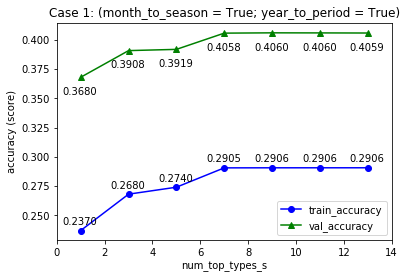

In [105]:
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
title_1 = "Case 1: (month_to_season = True; year_to_period = True)"
drawCharAccuracyLR(num_top_types_s, train_scores_LR_1, val_scores_LR_1, title_1)

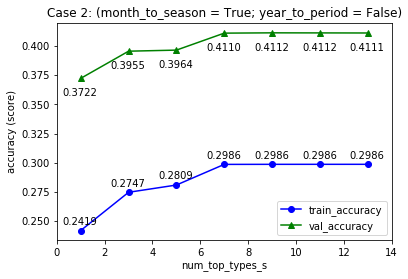

In [106]:
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
title_2 = "Case 2: (month_to_season = True; year_to_period = False)"
drawCharAccuracyLR(num_top_types_s, train_scores_LR_2, val_scores_LR_2, title_2)

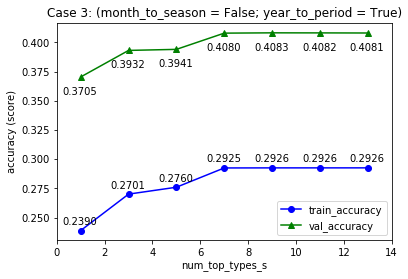

In [107]:
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
title_3 = "Case 3: (month_to_season = False; year_to_period = True)"
drawCharAccuracyLR(num_top_types_s, train_scores_LR_3, val_scores_LR_3, title_3)

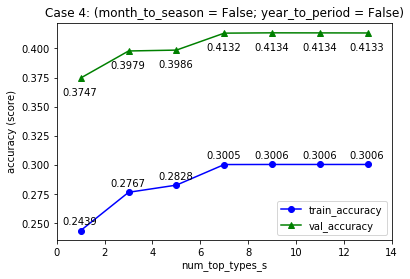

In [108]:
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
title_4 = "Case 4: (month_to_season = False; year_to_period = False)"
drawCharAccuracyLR(num_top_types_s, train_scores_LR_4, val_scores_LR_4, title_4)

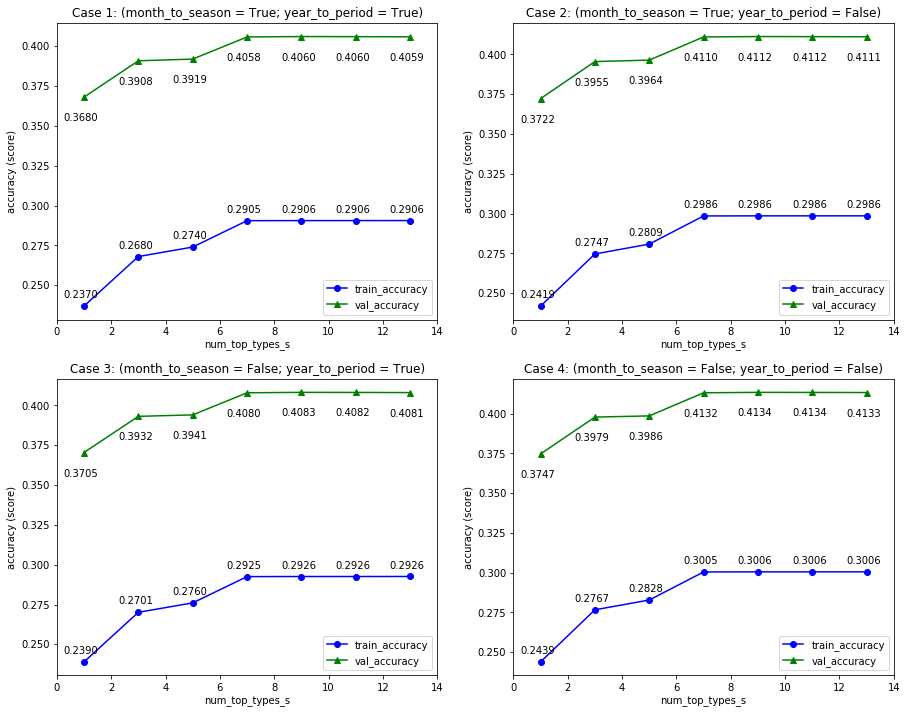

In [109]:
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
title_1 = "Case 1: (month_to_season = True; year_to_period = True)"
drawCharAccuracyLR(num_top_types_s, train_scores_LR_1, val_scores_LR_1, title_1)

plt.subplot(2, 2, 2)
title_2 = "Case 2: (month_to_season = True; year_to_period = False)"
drawCharAccuracyLR(num_top_types_s, train_scores_LR_2, val_scores_LR_2, title_2)

plt.subplot(2, 2, 3)
title_3 = "Case 3: (month_to_season = False; year_to_period = True)"
drawCharAccuracyLR(num_top_types_s, train_scores_LR_3, val_scores_LR_3, title_3)

plt.subplot(2, 2, 4)
title_4 = "Case 4: (month_to_season = False; year_to_period = False)"
drawCharAccuracyLR(num_top_types_s, train_scores_LR_4, val_scores_LR_4, title_4)

**Nhận xét:**

Mô hình `Linear Regression` quá yếu nên dự đoán bị `underfitting`, khi tăng chiều dữ liệu lên (cho các siêu tham số bằng False, tăng số lượng `num_top_types`) thì thấy giúp học tốt hơn một chút, nhưng vẫn bị `underfitting`.

In [112]:
# Tìm trường hợp có độ chính xác trên tập validation cao nhất khi dùng Linear Regression để huấn luyện.

best_val_score_LR_s = [best_val_score_LR_1, best_val_score_LR_2, best_val_score_LR_3, best_val_score_LR_4]
best_num_top_types_LR_s = [best_num_top_types_LR_1, best_num_top_types_LR_2, 
                           best_num_top_types_LR_3, best_num_top_types_LR_4]
best_case_LR_s = [1, 2, 3, 4]

best_val_score_LR = float('-inf')
best_num_top_types_LR = None
best_case_LR = None

for i in range(len(best_case_LR_s)):
    if best_val_score_LR_s[i] > best_val_score_LR:
        best_val_score_LR = best_val_score_LR_s[i]
        best_num_top_types_LR = best_num_top_types_LR_s[i]
        best_case_LR = best_case_LR_s[i]

print("Best Case of Linear Regression: " + str(best_case_LR))        
print("+ best_val_accuracy_LR: " + str(best_val_score_LR))
print("+ best_num_top_types_LR: " + str(best_num_top_types_LR))

Best Case of Linear Regression: 4
+ best_val_accuracy_LR: 0.4134189719024814
+ best_num_top_types_LR: 9


Như vậy với mô hình `Linear Regression` thì độ chính xác (score) trên tập validation thu được tốt nhất là `0.4134` với các siêu tham số `month_to_season` = False, `year_to_period` = False và `num_top_types` = 9.

### 3.2. K-Neighbors Regressor

In [14]:
# Tạo full pipeline bao gồm bước: tiền xử lý dữ liệu và mô hình hóa dữ liệu bằng K-Neighbors Regressor.
full_pipeline = Pipeline([("preprocess", preprocess_pipeline),
                          ("regression", KNeighborsRegressor())])

In [15]:
# Hàm runKNeighborsRegressor dùng để chạy mô hình K-Neighbors Regressor huấn luyện tập train và đánh giá 
# trên tập validaion.
# Input là train_X_df, train_y_sr, val_X_df, val_y_sr, full_pipeline, month_to_season, year_to_period,
# num_top_types_s và neighbors_s.
# Output là train_scores, val_scores, best_val_score, best_num_top_types và best_neighbors.
def runKNeighborsRegressor(train_X_df, train_y_sr, val_X_df, val_y_sr,
                           full_pipeline, month_to_season=True, year_to_period=True, 
                           num_top_types_s=[5], neighbors_s=[1]):
    train_scores = []
    val_scores = []
    
    best_val_score = float('-inf')
    best_num_top_types = None
    best_neighbors = None


    for num_top_types in num_top_types_s:
        for neighbors in neighbors_s:
            # Set các tham số mới cho full_pipeline
            full_pipeline.set_params(preprocess__date_sold__month_to_season=month_to_season,
                                     preprocess__year_built__year_to_period=year_to_period,
                                     preprocess__info_type__num_top_types=num_top_types,
                                     regression__n_neighbors=neighbors)
            
            # Fit full_pipeline vào tập huấn luyện
            full_pipeline.fit(train_X_df, train_y_sr)
    
            # Độ chính xác trên tập huấn luyện
            train_score = full_pipeline.score(train_X_df, train_y_sr)
    
            # Độ chính xác trên tập validation
            val_score = full_pipeline.score(val_X_df, val_y_sr)
        
            # Lưu lại các giá trị độ chính xác
            train_scores.append(train_score)
            val_scores.append(val_score)
        
            # Lưu lại best_val_score, best_num_top_types và best_neighbors
            if (val_score > best_val_score): 
                best_val_score = val_score
                best_num_top_types= num_top_types
                best_neighbors = neighbors
            
    return (train_scores, val_scores, best_val_score, best_num_top_types, best_neighbors)

**Trường hợp 1:**
- `month_to_season` = <span style="color:blue">True</span>.
- `num_top_types` = <span style="color:blue">True</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `neighbors_s` = [1, 3, 5, 7, 9, 11]

In [16]:
month_to_season = True
year_to_period = True
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
neighbors_s = [1, 3, 5, 7, 9, 11]

train_scores_KNR_1 = [] # KNR là viết tắt của K-Neighbors Regressor, số 1 là trường hợp 1
val_scores_KNR_1 = []

best_val_score_KNR_1 = float('-inf')
best_num_top_types_KNR_1 = None
best_neighbors_KNR_1 = None

# Chạy mô hình K-Neighbors Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runKNeighborsRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 neighbors_s)

train_scores_KNR_1 = results[0]
val_scores_KNR_1 = results[1]
best_val_score_KNR_1 = results[2]
best_num_top_types_KNR_1 = results[3] 
best_neighbors_KNR_1 = results[4] 

In [18]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_KNR_1)
print(val_scores_KNR_1)
print(best_val_score_KNR_1)

[0.9999360614376537, 0.8200177260688541, 0.7064865507995749, 0.5838814632813472, 0.5161012800271875, 0.4942195579489037, 0.9999361269673701, 0.920771771613693, 0.8378471950035016, 0.786629951927949, 0.7494873072008389, 0.694978782389124, 0.9999361269673701, 0.9078359051765575, 0.8425302018009853, 0.7945126207954679, 0.7520103232476401, 0.7037324840184253, 0.9999361269673701, 0.9078296737434606, 0.8425379710476135, 0.7945189560447373, 0.7520079438443126, 0.7037410955780843, 0.9999361269673701, 0.9078172698443473, 0.8425300686016907, 0.7945153355973378, 0.7520112353067631, 0.7037453676501733, 0.9999361269673701, 0.9078162458471166, 0.8425289981630127, 0.7945141680544783, 0.7520097115016487, 0.7037434327612949, 0.9999361269673701, 0.9078164786420998, 0.8425289844351473, 0.7945141920130491, 0.7520097290676494, 0.7037434517635471]
[0.8344523877994692, 0.7520157274666854, 0.6918879506118936, 0.6427502159343503, 0.5903107798668223, 0.5201157436495915, 0.8161253706849529, 0.7767240224365023, 0

**Trường hợp 2:**
- `month_to_season` = <span style="color:blue">True</span>.
- `num_top_types` = <span style="color:red">False</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `neighbors_s` = [1, 3, 5, 7, 9, 11]

In [25]:
month_to_season = True
year_to_period = False
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
neighbors_s = [1, 3, 5, 7, 9, 11]

train_scores_KNR_2 = [] # KNR là viết tắt của K-Neighbors Regressor, số 2 là trường hợp 2
val_scores_KNR_2 = []

best_val_score_KNR_2 = float('-inf')
best_num_top_types_KNR_2 = None
best_neighbors_KNR_2 = None

# Chạy mô hình K-Neighbors Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runKNeighborsRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 neighbors_s)

train_scores_KNR_2 = results[0]
val_scores_KNR_2 = results[1]
best_val_score_KNR_2 = results[2]
best_num_top_types_KNR_2 = results[3] 
best_neighbors_KNR_2 = results[4] 

In [26]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_KNR_2)
print(val_scores_KNR_2)
print(best_val_score_KNR_2)

[0.9999360614376537, 0.6527117375550572, 0.3345640642845195, 0.2864345081448668, 0.20399456294215046, 0.25287596491238595, 0.9999361269673701, 0.8645161325729412, 0.8044349015011498, 0.7451965660623129, 0.6351262160257447, 0.599354601458159, 0.9999361269673701, 0.8508329185389156, 0.8100263632427934, 0.7529079308883561, 0.6499124829027485, 0.5981294426371813, 0.9999361269673701, 0.8507987712647883, 0.810021394493491, 0.7529056377323634, 0.6499127191424918, 0.5981325815943294, 0.9999361269673701, 0.8508045677632433, 0.8100334999571113, 0.7529206388828186, 0.6499253935702336, 0.597122740316498, 0.9999361269673701, 0.8508231108329312, 0.8100431079897906, 0.7529259031493348, 0.649932060764608, 0.5971229109196283, 0.9999361269673701, 0.8508227162481405, 0.8100432012418932, 0.7529258585942691, 0.6499321021777821, 0.5971229099166576]
[0.7644689175027276, 0.6133487596836347, 0.46078574429108315, 0.45171568696154757, 0.3953133816644649, 0.369156346290047, 0.8353109891653219, 0.7889519720469049,

**Trường hợp 3:**
- `month_to_season` = <span style="color:red">False</span>.
- `num_top_types` = <span style="color:blue">True</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `neighbors_s` = [1, 3, 5, 7, 9, 11]

In [36]:
month_to_season = False
year_to_period = True
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
neighbors_s = [1, 3, 5, 7, 9, 11]

train_scores_KNR_3 = [] # KNR là viết tắt của K-Neighbors Regressor, số 3 là trường hợp 3
val_scores_KNR_3 = []

best_val_score_KNR_3 = float('-inf')
best_num_top_types_KNR_3 = None
best_neighbors_KNR_3 = None

# Chạy mô hình K-Neighbors Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runKNeighborsRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 neighbors_s)

train_scores_KNR_3 = results[0]
val_scores_KNR_3 = results[1]
best_val_score_KNR_3 = results[2]
best_num_top_types_KNR_3 = results[3] 
best_neighbors_KNR_3 = results[4] 

In [37]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_KNR_3)
print(val_scores_KNR_3)
print(best_val_score_KNR_3)

[0.9999993569957559, 0.8698327904939541, 0.737204463540945, 0.6319000301927411, 0.5639483477015322, 0.5743584736150533, 0.9999994617743753, 0.9347670616833337, 0.8890655176252095, 0.8337586183284807, 0.7632768292523147, 0.70725814491385, 0.9999994617743753, 0.9218369774913926, 0.8842602540982444, 0.8411472211691893, 0.7659121966632583, 0.7057069033008512, 0.9999994617743753, 0.9218274079315715, 0.884268006890657, 0.8411552733925665, 0.7659093318354665, 0.7057163590670911, 0.9999994617743753, 0.9218178255905342, 0.8842627040546358, 0.8411519471952463, 0.7659127987549076, 0.7057206596551552, 0.9999994617743753, 0.9218167438407806, 0.8842610339201458, 0.8411502008969174, 0.7659115000759295, 0.7057183513403468, 0.9999994617743753, 0.9218169267796528, 0.8842609009914488, 0.8411502431814375, 0.7659115380636986, 0.7057184088763137]
[0.8429331934332809, 0.7560434200078894, 0.7155080959302613, 0.6605585455709184, 0.5913493342662121, 0.5209996789252134, 0.8247278386556667, 0.7843182031893768, 0.

**Trường hợp 4:**
- `month_to_season` = <span style="color:red">False</span>.
- `num_top_types` = <span style="color:red">False</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `neighbors_s` = [1, 3, 5, 7, 9, 11]

In [38]:
month_to_season = False
year_to_period = False
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
neighbors_s = [1, 3, 5, 7, 9, 11]

train_scores_KNR_4 = [] # KNR là viết tắt của K-Neighbors Regressor, số 4 là trường hợp 4
val_scores_KNR_4 = []

best_val_score_KNR_4 = float('-inf')
best_num_top_types_KNR_4 = None
best_neighbors_KNR_4 = None

# Chạy mô hình K-Neighbors Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runKNeighborsRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 neighbors_s)

train_scores_KNR_4 = results[0]
val_scores_KNR_4 = results[1]
best_val_score_KNR_4 = results[2]
best_num_top_types_KNR_4 = results[3] 
best_neighbors_KNR_4 = results[4] 

In [39]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_KNR_4)
print(val_scores_KNR_4)
print(best_val_score_KNR_4)

[0.9999993569957559, 0.6766412268096573, 0.4304182494295261, 0.35955493594636645, 0.2524496335153872, 0.2968929244016505, 0.9999994617743753, 0.8634741101229821, 0.7907541111124321, 0.7264194886098123, 0.6586248932328977, 0.5861456725324985, 0.9999994617743753, 0.8503309870440299, 0.7867804364618182, 0.7341040132797708, 0.6603120606360533, 0.5946656120095984, 0.9999994617743753, 0.8502942979694976, 0.7867799335897059, 0.7341047557728028, 0.6603101162531315, 0.5946677945177422, 0.9999994617743753, 0.8503091510537738, 0.7867917465953698, 0.7341198491300565, 0.6587996017150661, 0.5906853113921025, 0.9999994617743753, 0.8503211793380455, 0.786808181111399, 0.7341277171096666, 0.658802364992316, 0.5906854020884064, 0.9999994617743753, 0.8503207847532548, 0.786808129627244, 0.734127853922264, 0.6588021948900555, 0.5906853574972861]
[0.7964641925507416, 0.7444984909833788, 0.568689797601249, 0.5178280844078684, 0.4416720261182131, 0.41447381089049057, 0.8352896116255859, 0.7896675452400574, 0

Bây giờ, nhóm sẽ tiến hành trực quan hóa kết quả thu được.

In [33]:
# Hàm visualizeResultKNR dùng để trực quan hóa kết quả của mô hình K-Neighbors Regression
# Input là rain_scores_KNR, val_scores_KNR, num_top_types_s và neighbors_s.
# Không có kiểu trả về.
def visualizeAccuracytKNR(train_scores_KNR, val_scores_KNR, num_top_types_s, neighbors_s):
    train_scores_df = pd.DataFrame(data=np.array(train_scores_KNR).reshape(len(num_top_types_s), -1),
                                 index=num_top_types_s, columns=neighbors_s)
    val_scores_df = pd.DataFrame(data=np.array(val_scores_KNR).reshape(len(num_top_types_s), -1), 
                               index=num_top_types_s, columns=neighbors_s)
    min_score = min(min(train_scores_KNR), min(val_scores_KNR))
    max_score = max(max(train_scores_KNR), max(val_scores_KNR))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True, 
                cbar=False, fmt='.4f', cmap='Greens')
    plt.title('train accuracies'); plt.xlabel('neighbors'); plt.ylabel('num_top_types');
    plt.subplot(1, 2, 2)
    sns.heatmap(val_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True, 
                cbar=False, fmt='.4f', cmap='Greens')
    plt.title('validation accuracies'); plt.xlabel('neighbors'); plt.ylabel('num_top_types');

Case 1: month_to_season = True and year_to_period = True
+ Best validation accuracy = 0.8344523877994692
+ Best number top types = 1
+ Best neighbors = 1


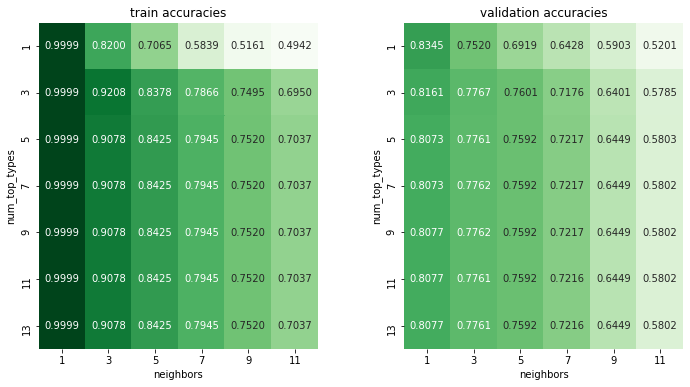

In [34]:
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
neighbors_s = [1, 3, 5, 7, 9, 11]

# Trực quan hóa kết quả của trường hợp 1.
print("Case 1: month_to_season = True and year_to_period = True")
print ("+ Best validation accuracy = " + str(best_val_score_KNR_1))
print ("+ Best number top types = " + str(best_num_top_types_KNR_1))
print ("+ Best neighbors = " + str(best_neighbors_KNR_1))
visualizeAccuracytKNR(train_scores_KNR_1, val_scores_KNR_1, num_top_types_s, neighbors_s)

Case 2: month_to_season = True and year_to_period = False
+ Best validation accuracy = 0.8353109891653219
+ Best number top types = 3
+ Best neighbors = 1


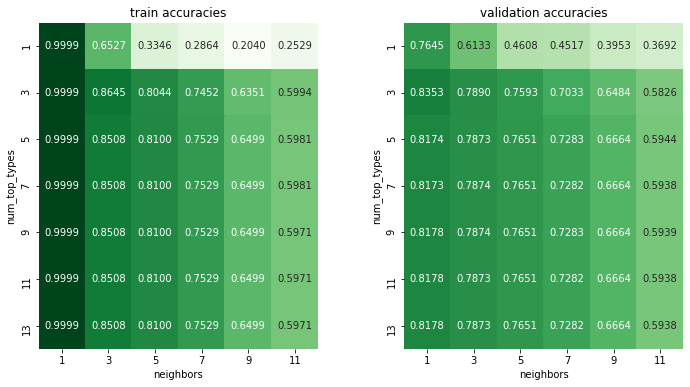

In [35]:
# Trực quan hóa kết quả của trường hợp 2.
print("Case 2: month_to_season = True and year_to_period = False")
print ("+ Best validation accuracy = " + str(best_val_score_KNR_2))
print ("+ Best number top types = " + str(best_num_top_types_KNR_2))
print ("+ Best neighbors = " + str(best_neighbors_KNR_2))
visualizeAccuracytKNR(train_scores_KNR_2, val_scores_KNR_2, num_top_types_s, neighbors_s)

Case 3: month_to_season = False and year_to_period = True
+ Best validation accuracy = 0.8429331934332809
+ Best number top types = 1
+ Best neighbors = 1


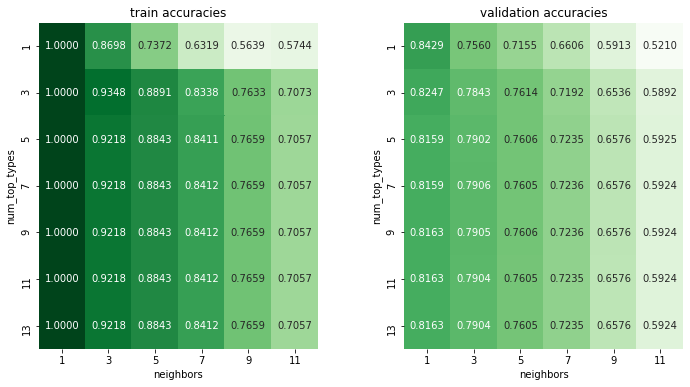

In [40]:
# Trực quan hóa kết quả của trường hợp 3.
print("Case 3: month_to_season = False and year_to_period = True")
print ("+ Best validation accuracy = " + str(best_val_score_KNR_3))
print ("+ Best number top types = " + str(best_num_top_types_KNR_3))
print ("+ Best neighbors = " + str(best_neighbors_KNR_3))
visualizeAccuracytKNR(train_scores_KNR_3, val_scores_KNR_3, num_top_types_s, neighbors_s)

Case 4: month_to_season = False and year_to_period = False
+ Best validation accuracy = 0.8352896116255859
+ Best number top types = 3
+ Best neighbors = 1


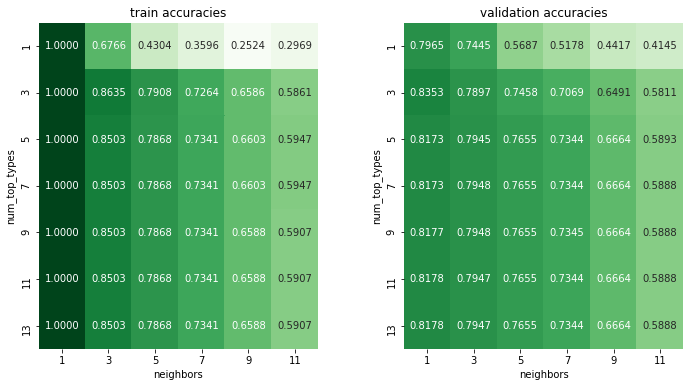

In [41]:
# Trực quan hóa kết quả của trường hợp 4.
print("Case 4: month_to_season = False and year_to_period = False")
print ("+ Best validation accuracy = " + str(best_val_score_KNR_4))
print ("+ Best number top types = " + str(best_num_top_types_KNR_4))
print ("+ Best neighbors = " + str(best_neighbors_KNR_4))
visualizeAccuracytKNR(train_scores_KNR_4, val_scores_KNR_4, num_top_types_s, neighbors_s)

**Nhận xét**:

Nhìn chung ta thấy rằng:
- `neightbors` càng tăng thì khiến mô hình càng bị underfitting, do có quá nhiều records láng giềng làm ảnh hưởng đến kết quả.
- `num_top_types` càng tăng thì càng giúp tăng độ chính xác trên cả 2 tập, nhưng đến một ngưỡng nào đó thì tăng thêm độ chính xác trên 2 tập vẫn vậy.

In [42]:
# Tìm trường hợp có độ chính xác (score) trên tập validation cao nhất khi dùng K-Neighbors Regressor để huấn luyện.

best_val_score_KNR_s = [best_val_score_KNR_1, best_val_score_KNR_2, best_val_score_KNR_3, best_val_score_KNR_4]
best_num_top_types_KNR_s = [best_num_top_types_KNR_1, best_num_top_types_KNR_2, 
                            best_num_top_types_KNR_3, best_num_top_types_KNR_4]
best_neighbors_KNR_s = [best_neighbors_KNR_1, best_neighbors_KNR_2, best_neighbors_KNR_3, best_neighbors_KNR_4]
best_case_KNR_s = [1, 2, 3, 4]

best_val_score_KNR = float('-inf')
best_num_top_types_KNR = None
best_neighbors_KNR = None
best_case_KNR = None

for i in range(len(best_case_KNR_s)):
    if best_val_score_KNR_s[i] > best_val_score_KNR:
        best_val_score_KNR = best_val_score_KNR_s[i]
        best_num_top_types_KNR = best_num_top_types_KNR_s[i]
        best_neighbors_KNR = best_neighbors_KNR_s[i]
        best_case_KNR = best_case_KNR_s[i]

print("Best Case of K-Neighbors Regressor: " + str(best_case_KNR))        
print("+ best_val_score_KNR: " + str(best_val_score_KNR))
print("+ best_num_top_types_KNR: " + str(best_num_top_types_KNR))
print("+ best_neighbors_KNR: " + str(best_neighbors_KNR))

Best Case of K-Neighbors Regressor: 3
+ best_val_score_KNR: 0.8429331934332809
+ best_num_top_types_KNR: 1
+ best_neighbors_KNR: 1


### 3.3. Decision Tree Regressor

In [43]:
# Tạo full pipeline bao gồm bước: tiền xử lý dữ liệu và mô hình hóa dữ liệu bằng Decision Tree Regressor.
# Phải cố định random_state bằng 0 như của nhóm, điều này giúp kết quả chạy ra đúng với của nhóm đã chạy.
full_pipeline = Pipeline([("preprocess", preprocess_pipeline),
                          ("regression", DecisionTreeRegressor(random_state=0))])

In [44]:
# Hàm runDecisionTreeRegressor dùng để chạy mô hình Decision Tree Regressor huấn luyện tập train và đánh giá 
# trên tập validaion.
# Input là train_X_df, train_y_sr, val_X_df, val_y_sr, full_pipeline, month_to_season, year_to_period,
# num_top_types_s và max_depth_s.
# Output là train_scores, val_scores, best_val_score, best_num_top_types và best_max_depth
def runDecisionTreeRegressor(train_X_df, train_y_sr, val_X_df, val_y_sr,
                             full_pipeline, month_to_season=True, year_to_period=True, 
                             num_top_types_s=[5], max_depth_s=[3]):
    train_scores = []
    val_scores = []
    
    best_val_score = float('-inf')
    best_num_top_types = None
    best_max_depth = None


    for num_top_types in num_top_types_s:
        for max_depth in max_depth_s:
            # Set các tham số mới cho full_pipeline
            full_pipeline.set_params(preprocess__date_sold__month_to_season=month_to_season,
                                     preprocess__year_built__year_to_period=year_to_period,
                                     preprocess__info_type__num_top_types=num_top_types,
                                     regression__max_depth=max_depth)
            
            # Fit full_pipeline vào tập huấn luyện
            full_pipeline.fit(train_X_df, train_y_sr)
    
            # Độ chính xác trên tập huấn luyện
            train_score = full_pipeline.score(train_X_df, train_y_sr)
    
            # Độ chính xác tên tập validation
            val_score = full_pipeline.score(val_X_df, val_y_sr)
        
            # Lưu lại các giá trị độ lỗi
            train_scores.append(train_score)
            val_scores.append(val_score)
        
            # Lưu lại best_val_score, best_num_top_types và best_neighbors
            if (val_score > best_val_score): 
                best_val_score = val_score
                best_num_top_types= num_top_types
                best_max_depth = max_depth
            
    return (train_scores, val_scores, best_val_score, best_num_top_types, best_max_depth)

**Trường hợp 1:**
- `month_to_season` = <span style="color:blue">True</span>.
- `num_top_types` = <span style="color:blue">True</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `max_depth_s` = [3, 5, 7, 9, 11, 13]

In [45]:
month_to_season = True
year_to_period = True
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
max_depth_s = [3, 5, 7, 9, 11, 13]

train_scores_DTR_1 = [] # DTR là viết tắt của Decision Tree Regressor, số 1 là trường hợp 1
val_scores_DTR_1 = []

best_val_score_DTR_1 = float('-inf')
best_num_top_types_DTR_1 = None
best_max_depth_DTR_1 = None

# Chạy mô hình Decision Tree Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runDecisionTreeRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 max_depth_s)

train_scores_DTR_1 = results[0]
val_scores_DTR_1 = results[1]
best_val_score_DTR_1 = results[2]
best_num_top_types_DTR_1 = results[3] 
best_max_depth_DTR_1 = results[4] 

In [46]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_DTR_1)
print(val_scores_DTR_1)
print(best_val_score_DTR_1)

[0.6104032897741045, 0.9507054819967908, 0.9781442004477688, 0.992420518588635, 0.9980757924550211, 0.9989592021163846, 0.8759386638776178, 0.9358105745085502, 0.957558008013283, 0.9835909294673028, 0.9973844356227265, 0.9991659457522295, 0.8759386638776178, 0.9358105745085502, 0.957558008013283, 0.983596489063099, 0.9973869905154996, 0.9991925758233278, 0.8759386638776178, 0.9358105745085502, 0.9575666538168963, 0.983602135790767, 0.9974051039521403, 0.9991905265264749, 0.8759386638776178, 0.9358105745085502, 0.9575666538168963, 0.983602135790767, 0.9974051039521403, 0.9991905265264749, 0.8759386638776178, 0.9358105745085502, 0.957558008013283, 0.9835982552702697, 0.9973883839899613, 0.999180636944657, 0.8759386638776178, 0.9358105745085502, 0.957558008013283, 0.9835982552702697, 0.9973883839899613, 0.999180636944657]
[0.646246915886458, 0.6627746276782085, 0.6673729349623035, 0.6638631013544467, 0.6563668886475558, 0.6567362290387758, 0.8931495473527119, 0.9000585165919324, 0.8992258

**Trường hợp 2:**
- `month_to_season` = <span style="color:blue">True</span>.
- `num_top_types` = <span style="color:red">Fasle</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `max_depth_s` = [3, 5, 7, 9, 11, 13]

In [49]:
month_to_season = True
year_to_period = False
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
max_depth_s = [3, 5, 7, 9, 11, 13]

train_scores_DTR_2 = [] # DTR là viết tắt của Decision Tree Regressor, số 2 là trường hợp 2
val_scores_DTR_2 = []

best_val_score_DTR_2 = float('-inf')
best_num_top_types_DTR_2 = None
best_max_depth_DTR_2 = None

# Chạy mô hình Decision Tree Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runDecisionTreeRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 max_depth_s)

train_scores_DTR_2 = results[0]
val_scores_DTR_2 = results[1]
best_val_score_DTR_2 = results[2]
best_num_top_types_DTR_2 = results[3] 
best_max_depth_DTR_2 = results[4] 

In [50]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_DTR_2)
print(val_scores_DTR_2)
print(best_val_score_DTR_2)

[0.6104032897741045, 0.9532348491189475, 0.9807319008674915, 0.9929193591612495, 0.9971930317100525, 0.9986647287886301, 0.8759386638776178, 0.9358105745085502, 0.9660245705137525, 0.9831274204751358, 0.9965789285961626, 0.9989665874105841, 0.8759386638776178, 0.9358105745085502, 0.9660245705137525, 0.9831274204751358, 0.996580774392683, 0.9989901864528752, 0.8759386638776178, 0.9358105745085502, 0.9660245705137525, 0.9831347436450807, 0.9965844662653436, 0.9989823878457034, 0.8759386638776178, 0.9358105745085502, 0.9660245705137525, 0.9831347436450807, 0.9965844662653436, 0.9989823878457034, 0.8759386638776178, 0.9358105745085502, 0.9660245705137525, 0.9831292600220951, 0.9965666933796202, 0.9989698017438111, 0.8759386638776178, 0.9358105745085502, 0.9660245705137525, 0.9831292600220951, 0.9965666933796202, 0.9989698017438111]
[0.646246915886458, 0.6911058907573493, 0.6965974939351177, 0.6671429275671583, 0.6925000508743936, 0.6968493780557186, 0.7679633394576206, 0.9000585165919324, 

**Trường hợp 3:**
- `month_to_season` = <span style="color:red">False</span>.
- `num_top_types` = <span style="color:blue">True</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `max_depth_s` = [3, 5, 7, 9, 11, 13]

In [52]:
month_to_season = False
year_to_period = True
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
max_depth_s = [3, 5, 7, 9, 11, 13]

train_scores_DTR_3 = [] # DTR là viết tắt của Decision Tree Regressor, số 3 là trường hợp 3
val_scores_DTR_3 = []

best_val_score_DTR_3 = float('-inf')
best_num_top_types_DTR_3 = None
best_max_depth_DTR_3 = None

# Chạy mô hình Decision Tree Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runDecisionTreeRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 max_depth_s)

train_scores_DTR_3 = results[0]
val_scores_DTR_3 = results[1]
best_val_score_DTR_3 = results[2]
best_num_top_types_DTR_3 = results[3] 
best_max_depth_DTR_3 = results[4] 

In [53]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_DTR_3)
print(val_scores_DTR_3)
print(best_val_score_DTR_3)

[0.6104032897741045, 0.9507054819967908, 0.9789323208213356, 0.992420518588635, 0.998077277947268, 0.9989781093299371, 0.8759386638776178, 0.9358105745085502, 0.9595333845804079, 0.9839327909197619, 0.9971715727474317, 0.9992013398461168, 0.8759386638776178, 0.9358105745085502, 0.9595333845804079, 0.9818783927655654, 0.9971810388980461, 0.9992290850482402, 0.8759386638776178, 0.9358105745085502, 0.9595420303840214, 0.9818840394932337, 0.9973045409188147, 0.9992270357513876, 0.8759386638776178, 0.9358105745085502, 0.9595420303840214, 0.9839993113567217, 0.9971991523346869, 0.9992270137194973, 0.8759386638776178, 0.9358105745085502, 0.9595333845804079, 0.9839954308362242, 0.9971824323725078, 0.9992171241376793, 0.8759386638776178, 0.9358105745085502, 0.9595333845804079, 0.9818801589727362, 0.9972878209566357, 0.9992171461695697]
[0.646246915886458, 0.7845287120247473, 0.6583617035132776, 0.664331044884521, 0.783473134609026, 0.6550275121439086, 0.8931495473527119, 0.9000585165919324, 0.8

**Trường hợp 4:**
- `month_to_season` = <span style="color:red">False</span>.
- `num_top_types` = <span style="color:red">False</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `max_depth_s` = [3, 5, 7, 9, 11, 13]

In [55]:
month_to_season = False
year_to_period = False
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
max_depth_s = [3, 5, 7, 9, 11, 13]

train_scores_DTR_4 = [] # DTR là viết tắt của Decision Tree Regressor, số 4 là trường hợp 4
val_scores_DTR_4 = []

best_val_score_DTR_4 = float('-inf')
best_num_top_types_DTR_4 = None
best_max_depth_DTR_4 = None

# Chạy mô hình Decision Tree Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runDecisionTreeRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 max_depth_s)

train_scores_DTR_4 = results[0]
val_scores_DTR_4 = results[1]
best_val_score_DTR_4 = results[2]
best_num_top_types_DTR_4 = results[3] 
best_max_depth_DTR_4 = results[4] 

In [56]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_DTR_4)
print(val_scores_DTR_4)
print(best_val_score_DTR_4)

[0.6104032897741045, 0.9532348491189475, 0.9815200212410584, 0.9929193591612495, 0.9971930355662508, 0.9986837914694596, 0.8759386638776178, 0.9358105745085502, 0.9678748135673587, 0.983918974649842, 0.9967872544413234, 0.998991178444796, 0.8759386638776178, 0.9358105745085502, 0.9678748135673587, 0.98603424651333, 0.9967141690804546, 0.9990250401219473, 0.8759386638776178, 0.9358105745085502, 0.9678748135673587, 0.9839262978197869, 0.9967927921105044, 0.9990069788799151, 0.8759386638776178, 0.9358105745085502, 0.9678748135673587, 0.9839262978197869, 0.9967927921105044, 0.9990069788799151, 0.8759386638776178, 0.9358105745085502, 0.9678748135673587, 0.9839208141968016, 0.996775019224781, 0.9990046554128832, 0.8759386638776178, 0.9358105745085502, 0.9678748135673587, 0.9860360860602895, 0.996775019224781, 0.998994392778023]
[0.646246915886458, 0.8119945031856529, 0.6901006853194848, 0.6642473637164157, 0.8301027358832477, 0.8310985528557913, 0.7679633394576206, 0.8921583652688597, 0.9266

Bây giờ, nhóm sẽ tiến hành trực quan hóa kết quả thu được.

In [47]:
# Hàm visualizeResultDTR dùng để trực quan hóa kết quả của mô hình Decision Tree Regression
# Input là train_scores_DTR, val_scores_DTR, num_top_types_s và max_depth_s
# Không có kiểu trả về.
def visualizeResultDTR(train_scores_DTR, val_scores_DTR, num_top_types_s, max_depth_s):
    train_scores_df = pd.DataFrame(data=np.array(train_scores_DTR).reshape(len(num_top_types_s), -1),
                                 index=num_top_types_s, columns=max_depth_s)
    val_scores_df = pd.DataFrame(data=np.array(val_scores_DTR).reshape(len(num_top_types_s), -1), 
                               index=num_top_types_s, columns=max_depth_s)
    min_score = min(min(train_scores_DTR), min(val_scores_DTR))
    max_score = max(max(train_scores_DTR), max(val_scores_DTR))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True, 
                cbar=False, fmt='.4f', cmap='Greens')
    plt.title('train accuracies'); plt.xlabel('max_depth'); plt.ylabel('num_top_types')
    plt.subplot(1, 2, 2)
    sns.heatmap(val_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True, 
                cbar=False, fmt='.4f', cmap='Greens')
    plt.title('validation accuracies'); plt.xlabel('max_depth'); plt.ylabel('num_top_types')

Case 1: month_to_season = True and year_to_period = True
+ Best validation accuracy = 0.9501443429601997
+ Best number top types = 7
+ Best max depth = 9


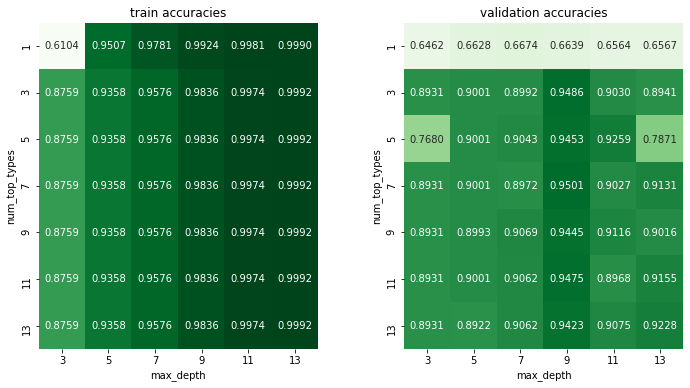

In [48]:
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
max_depth_s = [3, 5, 7, 9, 11, 13]

# Trực quan hóa kết quả của trường hợp 1.
print("Case 1: month_to_season = True and year_to_period = True")
print ("+ Best validation accuracy = " + str(best_val_score_DTR_1))
print ("+ Best number top types = " + str(best_num_top_types_DTR_1))
print ("+ Best max depth = " + str(best_max_depth_DTR_1))
visualizeResultDTR(train_scores_DTR_1, val_scores_DTR_1, num_top_types_s, max_depth_s)

Case 2: month_to_season = True and year_to_period = False
+ Best validation accuracy = 0.9395769200456041
+ Best number top types = 7
+ Best max depth = 11


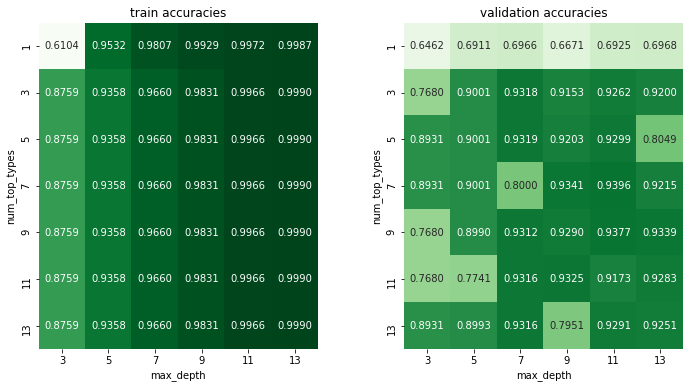

In [51]:
# Trực quan hóa kết quả của trường hợp 2.
print("Case 2: month_to_season = True and year_to_period = False")
print ("+ Best validation accuracy = " + str(best_val_score_DTR_2))
print ("+ Best number top types = " + str(best_num_top_types_DTR_2))
print ("+ Best max depth = " + str(best_max_depth_DTR_2))
visualizeResultDTR(train_scores_DTR_2, val_scores_DTR_2, num_top_types_s, max_depth_s)

Case 3: month_to_season = False and year_to_period = True
+ Best validation accuracy = 0.9486419721684871
+ Best number top types = 13
+ Best max depth = 9


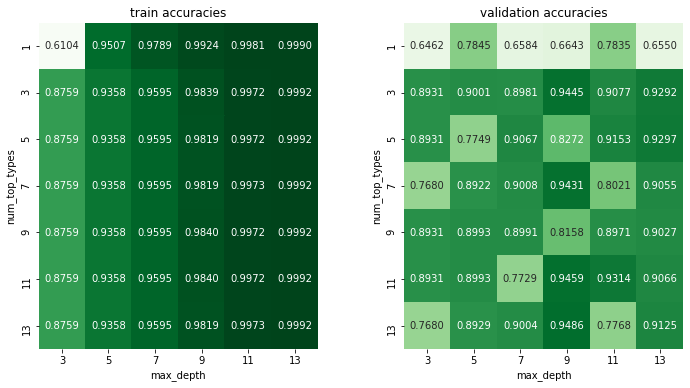

In [54]:
# Trực quan hóa kết quả của trường hợp 3.
print("Case 3: month_to_season = False and year_to_period = True")
print ("+ Best validation accuracy = " + str(best_val_score_DTR_3))
print ("+ Best number top types = " + str(best_num_top_types_DTR_3))
print ("+ Best max depth = " + str(best_max_depth_DTR_3))
visualizeResultDTR(train_scores_DTR_3, val_scores_DTR_3, num_top_types_s, max_depth_s)

Case 4: month_to_season = False and year_to_period = False
+ Best validation accuracy = 0.9363016606316428
+ Best number top types = 7
+ Best max depth = 11


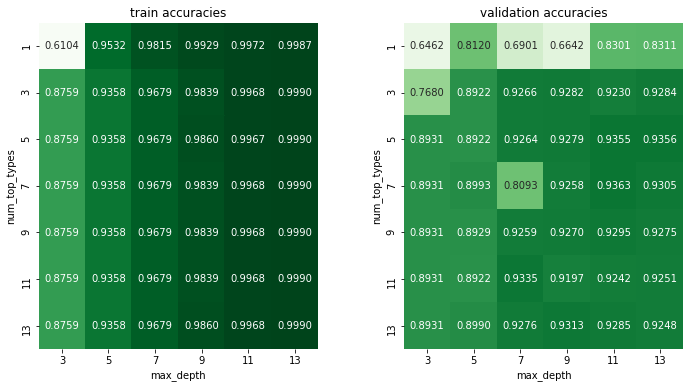

In [57]:
# Trực quan hóa kết quả của trường hợp 4.
print("Case 4: month_to_season = False and year_to_period = False")
print ("+ Best validation accuracy = " + str(best_val_score_DTR_4))
print ("+ Best number top types = " + str(best_num_top_types_DTR_4))
print ("+ Best max depth = " + str(best_max_depth_DTR_4))
visualizeResultDTR(train_scores_DTR_4, val_scores_DTR_4, num_top_types_s, max_depth_s)

**Nhận xét:**

Nhìn chung, ta thấy:
- `num_top_types` =  1 là trường hợp mô hình học không hiệu quả dù cho max_depth có bằng mấy.
- `num_top_types` ban đầu tang thì cũng giúp tăng độ chính xác (score) trên cả 2 tập, một lúc sau thì thấy độ chính xác (score) trên tập validation bắt đầu có dấu hiệu giảm xuống, thậm trí có vài trường hợp bị overfitting.
- `max_depth` càng tăng thì mô hình càng fit vào tập train nên có thể dẫn đến tình trạng bị overfitting.

In [58]:
# Tìm trường hợp có độ chính xác trên tập validation cao nhất khi dùng Decision Tree Regressor để huấn luyện.

best_val_score_DTR_s = [best_val_score_DTR_1, best_val_score_DTR_2, best_val_score_DTR_3, best_val_score_DTR_4]
best_num_top_types_DTR_s = [best_num_top_types_DTR_1, best_num_top_types_DTR_2, 
                            best_num_top_types_DTR_3, best_num_top_types_DTR_4]
best_max_depth_DTR_s = [best_max_depth_DTR_1, best_max_depth_DTR_2, best_max_depth_DTR_3, best_max_depth_DTR_4]
best_case_DTR_s = [1, 2, 3, 4]

best_val_score_DTR = float('-inf')
best_num_top_types_DTR = None
best_max_depth_DTR = None
best_case_DTR = None

for i in range(len(best_case_DTR_s)):
    if best_val_score_DTR_s[i] > best_val_score_DTR:
        best_val_score_DTR = best_val_score_DTR_s[i]
        best_num_top_types_DTR = best_num_top_types_DTR_s[i]
        best_max_depth_DTR = best_max_depth_DTR_s[i]
        best_case_DTR = best_case_DTR_s[i]

print("Best Case of Decision Tree Regressor: " + str(best_case_DTR))        
print("+ best_val_score_DTR: " + str(best_val_score_DTR))
print("+ best_num_top_types_DTR: " + str(best_num_top_types_DTR))
print("+ best_max_depth_DTR: " + str(best_max_depth_DTR))

Best Case of Decision Tree Regressor: 1
+ best_val_score_DTR: 0.9501443429601997
+ best_num_top_types_DTR: 7
+ best_max_depth_DTR: 9


### 3.4. Random Forest Regressor

In [59]:
# Tạo full pipeline bao gồm bước: tiền xử lý dữ liệu và mô hình hóa dữ liệu bằng Random Forest Regressor
# Phải cố định n_estimators (số lượng cây) là 10 và random_state bằng 0 như của nhóm, 
# điều này giúp kết quả chạy ra đúng với của nhóm đã chạy.
full_pipeline = Pipeline([("preprocess", preprocess_pipeline),
                          ("regression", RandomForestRegressor(n_estimators=10, random_state=0))])

In [61]:
# Hàm runRandomForestRegressor dùng để chạy mô hình Random Forest Regressor huấn luyện tập train và đánh giá 
# trên tập validaion.
# Bên trong hàm giống với hàm runDecisionTreeRegressor, chỉ đổi tên cho rõ rãng từng bước thôi.
# Input là train_X_df, train_y_sr, val_X_df, val_y_sr, full_pipeline, month_to_season, year_to_period,
# num_top_types_s và max_depth_s.
# Output là train_scores, val_scores, best_val_score, best_num_top_types và best_max_depth.
def runRandomForestRegressor(train_X_df, train_y_sr, val_X_df, val_y_sr,
                             full_pipeline, month_to_season=True, year_to_period=True, 
                             num_top_types_s=[5], max_depth_s=[3]):
    train_scores = []
    val_scores = []
    
    best_val_score = float('-inf')
    best_num_top_types = None
    best_max_depth = None


    for num_top_types in num_top_types_s:
        for max_depth in max_depth_s:
            # Set các tham số mới cho full_pipeline
            full_pipeline.set_params(preprocess__date_sold__month_to_season=month_to_season,
                                     preprocess__year_built__year_to_period=year_to_period,
                                     preprocess__info_type__num_top_types=num_top_types,
                                     regression__max_depth=max_depth)
            
            # Fit full_pipeline vào tập huấn luyện
            full_pipeline.fit(train_X_df, train_y_sr)
    
            # Độ chính xác trên tập huấn luyện
            train_score = full_pipeline.score(train_X_df, train_y_sr)
    
            # Độ chính xác tên tập validation
            val_score = full_pipeline.score(val_X_df, val_y_sr)
        
            # Lưu lại các giá trị độ lỗi
            train_scores.append(train_score)
            val_scores.append(val_score)
        
            # Lưu lại best_val_score, best_num_top_types và best_neighbors
            if (val_score > best_val_score): 
                best_val_score = val_score
                best_num_top_types= num_top_types
                best_max_depth = max_depth
            
    return (train_scores, val_scores, best_val_score, best_num_top_types, best_max_depth)

**Trường hợp 1:**
- `month_to_season` = <span style="color:blue">True</span>.
- `num_top_types` = <span style="color:blue">True</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `max_depth_s` = [3, 5, 7, 9, 11, 13]

In [62]:
month_to_season = True
year_to_period = True
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
max_depth_s = [3, 5, 7, 9, 11, 13]

train_scores_RFR_1 = [] # DTR là viết tắt của Random Forest Regressor, số 1 là trường hợp 1
val_scores_RFR_1 = []

best_val_score_RFR_1 = float('-inf')
best_num_top_types_RFR_1 = None
best_max_depth_RFR_1 = None

# Chạy mô hình Random Forest Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runRandomForestRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 max_depth_s)

train_scores_RFR_1 = results[0]
val_scores_RFR_1 = results[1]
best_val_score_RFR_1 = results[2]
best_num_top_types_RFR_1 = results[3] 
best_max_depth_RFR_1 = results[4] 

In [63]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_RFR_1)
print(val_scores_RFR_1)
print(best_val_score_RFR_1)

[0.722070897654631, 0.9298246387216108, 0.9551887132136369, 0.962847997160714, 0.9682208795648971, 0.9625696260888916, 0.8724988561125041, 0.9285220628996301, 0.9569784962417232, 0.9635713068596281, 0.9659501772292641, 0.9656118331708317, 0.8730655910957145, 0.9247988011079146, 0.9542608870362247, 0.9677169634028537, 0.9704125486468085, 0.9697008834224311, 0.873051308071416, 0.9283058456068581, 0.9554361801026018, 0.9671835025940555, 0.9697642760648344, 0.9702252814063985, 0.8730655910957145, 0.9254931907604137, 0.9571050699298401, 0.9672101067988327, 0.970353040361841, 0.9697535035709671, 0.8730086141985017, 0.9239101042857121, 0.9562838086861568, 0.9654442051340043, 0.9692708580771044, 0.9683920910789403, 0.8733708243442343, 0.9272826653107845, 0.9550851615107272, 0.9678922226833606, 0.9641684257572488, 0.9707773006952015]
[0.6825932368267127, 0.7351161975558844, 0.7942777374991166, 0.7663742629831513, 0.7141549720692312, 0.7746470708870321, 0.9013971272191166, 0.9123393420931961, 0.

**Trường hợp 2:**
- `month_to_season` = <span style="color:blue">True</span>.
- `num_top_types` = <span style="color:red">False</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `max_depth_s` = [3, 5, 7, 9, 11, 13]

In [70]:
month_to_season = True
year_to_period = False
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
max_depth_s = [3, 5, 7, 9, 11, 13]

train_scores_RFR_2 = [] # DTR là viết tắt của Random Forest Regressor, số 2 là trường hợp 2
val_scores_RFR_2 = []

best_val_score_RFR_2 = float('-inf')
best_num_top_types_RFR_2 = None
best_max_depth_RFR_2 = None

# Chạy mô hình Random Forest Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runRandomForestRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 max_depth_s)

train_scores_RFR_2 = results[0]
val_scores_RFR_2 = results[1]
best_val_score_RFR_2 = results[2]
best_num_top_types_RFR_2 = results[3] 
best_max_depth_RFR_2 = results[4] 

In [71]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_RFR_2)
print(val_scores_RFR_2)
print(best_val_score_RFR_2)

[0.7245118995015212, 0.9296342245249926, 0.9586267226521392, 0.9662046069749022, 0.9642911989477977, 0.9681183762896421, 0.8725393738965826, 0.9307767397368534, 0.9596654476229983, 0.9642034642428532, 0.9692697516879165, 0.9646900771275363, 0.8724418792152915, 0.931899817656786, 0.9592527431695059, 0.9670372430272617, 0.9682990845136801, 0.969188636292688, 0.8734252923559425, 0.9309629310766969, 0.9591255728738614, 0.9668603947655717, 0.9691166176117336, 0.9663134868716629, 0.8725533241242124, 0.9310545315891929, 0.9596782602966971, 0.9624336483646638, 0.966447037400043, 0.9695719516955564, 0.8725963507937953, 0.9310728273257238, 0.9595680732430305, 0.9657405588382245, 0.9658088587324697, 0.9683681447524561, 0.8729538133901251, 0.9316263186536828, 0.9581098038378432, 0.9634364471801156, 0.9701645795372121, 0.9691244044413434]
[0.6489405719425451, 0.7871962312769292, 0.7379296314806039, 0.815755767323375, 0.791234909054575, 0.7915956264118857, 0.9031497341296479, 0.9202980272497348, 0.9

**Trường hợp 3:**
- `month_to_season` = <span style="color:red">False</span>.
- `num_top_types` = <span style="color:blue">True</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `max_depth_s` = [3, 5, 7, 9, 11, 13]

In [73]:
month_to_season = False
year_to_period = True
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
max_depth_s = [3, 5, 7, 9, 11, 13]

train_scores_RFR_3 = [] # DTR là viết tắt của Random Forest Regressor, số 3 là trường hợp 3
val_scores_RFR_3 = []

best_val_score_RFR_3 = float('-inf')
best_num_top_types_RFR_3 = None
best_max_depth_RFR_3 = None

# Chạy mô hình Random Forest Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runRandomForestRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 max_depth_s)

train_scores_RFR_3 = results[0]
val_scores_RFR_3 = results[1]
best_val_score_RFR_3 = results[2]
best_num_top_types_RFR_3 = results[3] 
best_max_depth_RFR_3 = results[4] 

In [74]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_RFR_3)
print(val_scores_RFR_3)
print(best_val_score_RFR_3)

[0.7216775924523882, 0.9272569484694673, 0.963163632213259, 0.9613035885583648, 0.964891719863095, 0.9632939525846578, 0.8725894956445185, 0.9235680950666392, 0.954720233963802, 0.9677736562200857, 0.9695437304603953, 0.968094704406094, 0.8725894956445185, 0.9281901366379973, 0.9565433505686646, 0.9683037974481331, 0.9690866672612635, 0.9702931641707228, 0.8725963507937953, 0.9235882197307651, 0.956687877927072, 0.9677741806002589, 0.9663826147080229, 0.9699831314633247, 0.8724988561125041, 0.9283543216027372, 0.9528352062018381, 0.9679777943533884, 0.9699674073367655, 0.9698492229854156, 0.8724418792152915, 0.9292367391144525, 0.9582540542971834, 0.9644372689314532, 0.9647233232463245, 0.9644794202564413, 0.8725963507937953, 0.9277520151152746, 0.9583744838584335, 0.9670401578471388, 0.9636050624435123, 0.9695790793539262]
[0.7032033206478365, 0.7809549339419742, 0.8308154468516787, 0.8128008678460604, 0.8486828263575592, 0.7852914488069491, 0.8897462746147626, 0.9031978975687426, 0.9

**Trường hợp 4:**
- `month_to_season` = <span style="color:red">False</span>.
- `num_top_types` = <span style="color:red">False</span>.
- `num_top_types_s` = [1, 3, 5, 7, 9, 11, 13]
- `max_depth_s` = [3, 5, 7, 9, 11, 13]

In [76]:
month_to_season = False
year_to_period = False
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
max_depth_s = [3, 5, 7, 9, 11, 13]

train_scores_RFR_4 = [] # DTR là viết tắt của Random Forest Regressor, số 4 là trường hợp 4
val_scores_RFR_4 = []

best_val_score_RFR_4 = float('-inf')
best_num_top_types_RFR_4 = None
best_max_depth_RFR_4 = None

# Chạy mô hình Random Forest Regressor cho các tham số trên và ghi nhận các kết quả độ chính xác.
results = runRandomForestRegressor(train_X_df, train_y_sr,
                                 val_X_df, val_y_sr,
                                 full_pipeline, 
                                 month_to_season, 
                                 year_to_period, 
                                 num_top_types_s, 
                                 max_depth_s)

train_scores_RFR_4 = results[0]
val_scores_RFR_4 = results[1]
best_val_score_RFR_4 = results[2]
best_num_top_types_RFR_4 = results[3] 
best_max_depth_RFR_4 = results[4] 

In [77]:
# Xem thử độ chính xác (score) thu được.
print(train_scores_RFR_4)
print(val_scores_RFR_4)
print(best_val_score_RFR_4)

[0.7264226604819969, 0.929590944735533, 0.9578033383512696, 0.9653864773387305, 0.9674237768821516, 0.9687360044172532, 0.8725393738965826, 0.930692813502235, 0.9559638710654838, 0.9668736875170222, 0.9681116783690126, 0.9690956166497973, 0.8729680964144235, 0.9305906049603266, 0.9598864808585023, 0.9664872898448602, 0.9694715990353734, 0.9705559895847765, 0.8733708243442343, 0.9312615196401116, 0.9593134483928447, 0.9663543990508211, 0.9659621704957889, 0.9695035100441999, 0.8730943347409987, 0.93197428507986, 0.9564617661625348, 0.9673921707061504, 0.9679145666417105, 0.967951635639394, 0.8734683190255251, 0.9313450797366681, 0.9611394084689293, 0.9637935803080182, 0.9682661815287802, 0.9699148491627279, 0.8684390017770831, 0.9282512865303253, 0.9569437994843107, 0.9667049750704493, 0.9661650812441769, 0.9699848567864592]
[0.6659439432109957, 0.8379308705657705, 0.8297491096677857, 0.8181795634165935, 0.8045492084121904, 0.8403895444161962, 0.9031497341296479, 0.9203411265008793, 0.9

Bây giờ, nhóm sẽ tiến hành trực quan hóa kết quả thu được.

In [68]:
# Hàm visualizeResultRFR dùng để trực quan hóa kết quả của mô hình Random Forest Regressor
# Input là train_scores_RFR, val_scores_RFR, num_top_types_s và max_depth_s
# Không có kiểu trả về.
def visualizeResultRFR(train_scores_RFR, val_scores_RFR, num_top_types_s, max_depth_s):
    train_scores_df = pd.DataFrame(data=np.array(train_scores_RFR).reshape(len(num_top_types_s), -1),
                                 index=num_top_types_s, columns=max_depth_s)
    val_scores_df = pd.DataFrame(data=np.array(val_scores_RFR).reshape(len(num_top_types_s), -1), 
                               index=num_top_types_s, columns=max_depth_s)
    min_score = min(min(train_scores_RFR), min(val_scores_RFR))
    max_score = max(max(train_scores_RFR), max(val_scores_RFR))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True, 
                cbar=False, fmt='.4f', cmap='Greens')
    plt.title('train accuracies'); plt.xlabel('max_depth'); plt.ylabel('num_top_types')
    plt.subplot(1, 2, 2)
    sns.heatmap(val_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True, 
                cbar=False, fmt='.4f', cmap='Greens')
    plt.title('validation accuracies'); plt.xlabel('max_depth'); plt.ylabel('num_top_types')

Case 1: month_to_season = True and year_to_period = True
+ Best validation accuracy = 0.9320256499338074
+ Best number top types = 9
+ Best max depth = 13


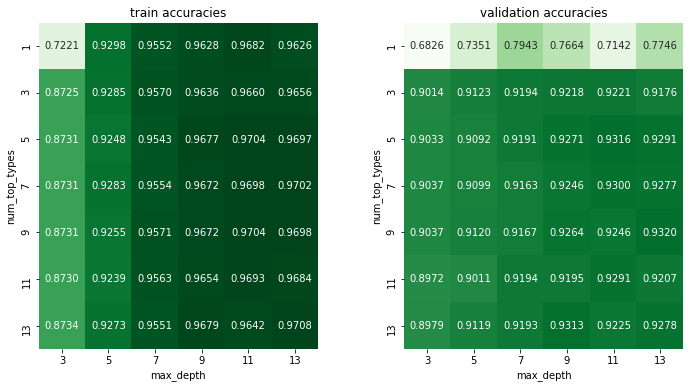

In [69]:
num_top_types_s = [1, 3, 5, 7, 9, 11, 13]
max_depth_s = [3, 5, 7, 9, 11, 13]

# Trực quan hóa kết quả của trường hợp 1.
print("Case 1: month_to_season = True and year_to_period = True")
print ("+ Best validation accuracy = " + str(best_val_score_RFR_1))
print ("+ Best number top types = " + str(best_num_top_types_RFR_1))
print ("+ Best max depth = " + str(best_max_depth_RFR_1))
visualizeResultRFR(train_scores_RFR_1, val_scores_RFR_1, num_top_types_s, max_depth_s)

Case 2: month_to_season = True and year_to_period = False
+ Best validation accuracy = 0.9408644981585681
+ Best number top types = 5
+ Best max depth = 11


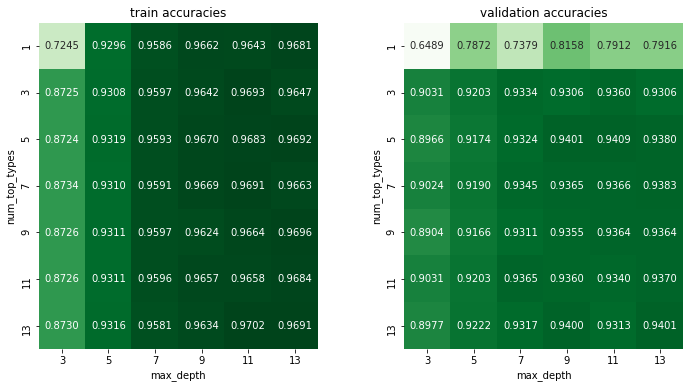

In [72]:
# Trực quan hóa kết quả của trường hợp 2.
print("Case 2: month_to_season = True and year_to_period = False")
print ("+ Best validation accuracy = " + str(best_val_score_RFR_2))
print ("+ Best number top types = " + str(best_num_top_types_RFR_2))
print ("+ Best max depth = " + str(best_max_depth_RFR_2))
visualizeResultRFR(train_scores_RFR_2, val_scores_RFR_2, num_top_types_s, max_depth_s)

Case 3: month_to_season = False and year_to_period = True
+ Best validation accuracy = 0.9304263213843312
+ Best number top types = 7
+ Best max depth = 9


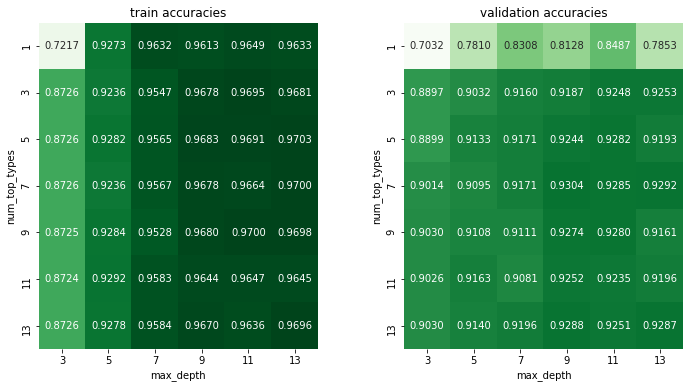

In [75]:
# Trực quan hóa kết quả của trường hợp 3.
print("Case 3: month_to_season = False and year_to_period = True")
print ("+ Best validation accuracy = " + str(best_val_score_RFR_3))
print ("+ Best number top types = " + str(best_num_top_types_RFR_3))
print ("+ Best max depth = " + str(best_max_depth_RFR_3))
visualizeResultRFR(train_scores_RFR_3, val_scores_RFR_3, num_top_types_s, max_depth_s)

Case 4: month_to_season = False and year_to_period = False
+ Best validation accuracy = 0.9434249374382878
+ Best number top types = 9
+ Best max depth = 9


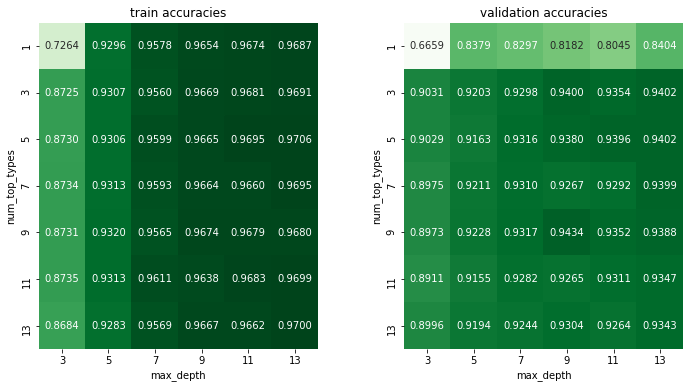

In [78]:
# Trực quan hóa kết quả của trường hợp 4.
print("Case 4: month_to_season = False and year_to_period = False")
print ("+ Best validation accuracy = " + str(best_val_score_RFR_4))
print ("+ Best number top types = " + str(best_num_top_types_RFR_4))
print ("+ Best max depth = " + str(best_max_depth_RFR_4))
visualizeResultRFR(train_scores_RFR_4, val_scores_RFR_4, num_top_types_s, max_depth_s)

**Nhận xét:**

Nhìn chung, ta thấy: sự ảnh hưởng của các siêu tham số đến độ lỗi trên 2 tập là khá tương tư như trong mô hình Decision Tree Regressor, chỉ khác ở đây là dùng nhiều cây (mặc định 10 cây) và độ lỗi trên tập train tăng (giảm) thì độ lỗi trên tập validation cũng tăng (giảm) theo.

In [80]:
# Tìm trường hợp có độ lỗi trên tập validation bé nhất khi dùng Random Forest Regressor để huấn luyện.

best_val_score_RFR_s = [best_val_score_RFR_1, best_val_score_RFR_2, best_val_score_RFR_3, best_val_score_RFR_4]
best_num_top_types_RFR_s = [best_num_top_types_RFR_1, best_num_top_types_RFR_2, 
                            best_num_top_types_RFR_3, best_num_top_types_RFR_4]
best_max_depth_RFR_s = [best_max_depth_RFR_1, best_max_depth_RFR_2, best_max_depth_RFR_3, best_max_depth_RFR_4]
best_case_RFR_s = [1, 2, 3, 4]

best_val_score_RFR = float('-inf')
best_num_top_types_RFR = None
best_max_depth_RFR = None
best_case_RFR = None

for i in range(len(best_case_RFR_s)):
    if best_val_score_RFR_s[i] > best_val_score_RFR:
        best_val_score_RFR = best_val_score_RFR_s[i]
        best_num_top_types_RFR = best_num_top_types_RFR_s[i]
        best_max_depth_RFR = best_max_depth_RFR_s[i]
        best_case_RFR = best_case_RFR_s[i]

print("Best Case of Random Forest Regressor: " + str(best_case_RFR))        
print("+ best_val_score_RFR: " + str(best_val_score_RFR))
print("+ best_num_top_types_RFR: " + str(best_num_top_types_RFR))
print("+ best_max_depth_RFR: " + str(best_max_depth_RFR))

Best Case of Random Forest Regressor: 4
+ best_val_score_RFR: 0.9434249374382878
+ best_num_top_types_RFR: 9
+ best_max_depth_RFR: 9


### 3.5. Chọn mô hình tốt nhất và huấn luyện trên toàn bộ tập train

- Mô hình Linear Regression:
    + Độ chính xác (score) cao nhất trên tập validation: 0.4134
    + Các siêu tham số: `month_to_season` = False, `year_to_period` = False, `num_top_types` = 9

- Mô hình K-Neighbors Regressor:
    + Độ chính xác (score) cao nhất trên tập validation: 0.8429
    + Các siêu tham số: `month_to_season` = False, `year_to_period` = True, `num_top_types` = 1, `neighbors` = 1

- Mô hình Decision Tree Regressor:
    + Độ chính xác (score) cao nhất trên tập validation: 0.9501
    + Các siêu tham số: `month_to_season` = True, `year_to_period` = True, `num_top_types` = 7, `max_depth` = 9

- Mô hình Random Forest Regressor:
    + Độ chính xác (score) cao nhất trên tập validation: 0.9434
    + Các siêu tham số: `month_to_season` = Fasle, `year_to_period` = False, `num_top_types` = 9, `max_depth` = 9

**<span style="color:red">Mô hình chiến thắng là mô hình Decision Tree Regressor đạt độ lỗi trên tập validation là 4.93% và có các siêu tham số `month_to_season` = True, `year_to_period` = True, `num_top_types` = 7, `max_depth` = 9.</span>**

In [54]:
'''
import pandas as pd
data_df = pd.read_csv("data/Orange-County/train-data-2019.csv", sep='\t')
# Tách X và y
y_sr = data_df["sold_price"] # sr là viết tắt của series
X_df = data_df.drop("sold_price", axis=1)
'''

,address_street,address_locality,address_region,address_code,date_sold,mortgage,info_type,info_bedrooms,info_bathrooms,info_size,...,taxes_land,taxes_improvements,taxes_total,taxes_taxes,school,total_crime,violent_crime,property_crime,foreclosures,year_sold
0,13242 Amarillo Dr,Westminster,CA,92683,10/24/2019,3157.0,Single Family Residence,3.0,1.0,1090.0,...,508260.0,54780.0,563040.0,6969 (1.23 %),3,97.0,79.0,140.0,4,2019
1,716 S Palomino Ln,Anaheim,CA,92807,08/16/2019,2748.0,Single Family Residence,3.0,3.0,1582.0,...,371674.0,148526.0,520200.0,5527 (1.06 %),3,88.0,71.0,127.0,4,2019
2,19702 Lancewood Plz,Yorba Linda,CA,92886,07/23/2019,2966.0,Single Family Residence,4.0,2.0,1440.0,...,29459.0,43373.0,72832.0,1240 (1.70 %),3,22.0,12.0,44.0,4,2019
3,25885 Trabuco Rd Apt 59,Lake Forest,CA,92630,10/30/2019,1726.0,Condominium,2.0,2.0,1190.0,...,112879.0,93656.0,206535.0,2096 (1.01 %),3,29.0,23.0,42.0,4,2019
4,6742 Gate Hill Cir,Huntington Beach,CA,92648,07/15/2019,5860.0,Single Family Residence,4.0,3.0,2193.0,...,159764.0,148957.0,308721.0,3706 (1.20 %),3,57.0,47.0,82.0,4,2019


In [81]:
# Tạo full pipeline bao gồm bước: tiền xử lý dữ liệu và mô hình hóa dữ liệu bằng Decision Tree Regressor.
# Phải cố định random_state bằng 0 như của nhóm, điều này giúp kết quả chạy ra đúng với của nhóm đã chạy.
full_pipeline = Pipeline([("preprocess", preprocess_pipeline),
                          ("regression", DecisionTreeRegressor(random_state=0))])

In [82]:
# Các tham số tốt nhất của mô hình
best_month_to_season = True
best_year_to_period = True
best_num_top_types = best_num_top_types_DTR # 7
best_max_depth = best_max_depth_DTR # 9

# Set các tham số mới cho full_pipeline
full_pipeline.set_params(preprocess__date_sold__month_to_season=best_month_to_season,
                         preprocess__year_built__year_to_period=best_year_to_period,
                         preprocess__info_type__num_top_types=best_num_top_types,
                         regression__max_depth=best_max_depth)

# Fit full_pipeline vào toàn bộ dữ liệu
full_pipeline.fit(X_df, y_sr)

Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=None,
                          steps=[('address', AddressProcessor()),
                                 ('date_sold',
                                  DateSoldProcessor(month_to_season=True)),
                                 ('info_type',
                                  InfoTypeProcessor(num_top_types=7)),
                                 ('year_built',
                                  YearBuiltProcessor(year_to_period=True)),
                                 ('col_dropper', ColumnDropper()),
                                 ('taxes', TaxesProcessor()),
                                 ('column_transformer',
                                  ColumnTran...
                                  StandardScaler(copy=True, with_mean=False,
                                                 with_std=True))],
                          verbose=False)),
                ('regression',
                 DecisionT

## 4. Dự đoán trên tập `test`

**<span style="color:red">Đến tận bây giờ, nhóm mới mở tập test ra để đo độ lỗi của mô hình tốt nhất.</span>**

In [83]:
test_df = pd.read_csv("data/Orange-County/test-data-2019.csv", sep='\t')

In [84]:
# Tách X và y
test_y_sr = test_df["sold_price"] # sr là viết tắt của series
test_X_df = test_df.drop("sold_price", axis=1)

In [85]:
# Độ chính xác trên tập huấn luyện
train_score = full_pipeline.score(X_df, y_sr)
    
# Độ chính xác tên tập validation
test_score = full_pipeline.score(test_X_df, test_y_sr)

print("Train Acurancy: " + str(train_score) + "%")
print("Test Acurancy: " + str(test_score) + "%")

Train Acurancy: 0.9907124037344204%
Test Acurancy: 0.9477162124340994%


# Hết